# Players ranking

In [907]:
import sys
import os
import pandas as pd
import numpy as np
import datetime, time
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import statsmodels.api as sm
from statsmodels.formula.api import ols
from pylab import hist, show
import scipy
import zipfile
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
import seaborn as sn
from sklearn.metrics import silhouette_samples, silhouette_score


sys.setrecursionlimit(100000)
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 200)

In [908]:
pwd

'/Users/stefanostselios/Desktop/nhl_roster_design-master'

### import play by play dataframe

In [909]:
da = pd.read_csv('/Users/stefanostselios/Brock University/Kevin Mongeon - StephanosShare/out/pbp_merged.csv')
#da = pd.read_csv('/Users/kevinmongeon/Brock University/Steve Tselios - StephanosShare/out/pbp_merged.csv')
da = da.drop('Unnamed: 0', axis=1)
da = da.rename(columns={'TeamCode': 'EventTeamCode'})

- keep regular season games and events that happened in regulation and overtime (exclude shootouts). Drop rows that have 'NaN' in event number column and irrelevant data.

In [910]:
da = da[da['GameNumber'] <= 21230]
da = da[da['Period'] <= 4]
da = da[da['Period'] >= 1]
da = da[da['EventType']!='STOP']
da = da[da['EventType']!='EISTR']
da = da[da['EventType']!='EIEND']
da = da[da['EventType'] !='FIGHT']
da = da[da['PlayerName'] !='TEAM']
da = da[da['EventTeamCode'] != 'Neu']
da = da[da['EventTeamCode'] != 'Def']
da = da.dropna(subset=['EventNumber'])

In [911]:
da.shape

(314373, 44)

## shots against

- calculate the shots against each player faced througout the duration of a season. Drop duplicates and eep one observation per player.

In [912]:
dsa = da.copy()
dsa['AdvantageType'] = dsa.groupby(['Season','GameNumber', 'Period'])['AdvantageType'].apply(lambda x: x.bfill())
#dsa.head()

In [913]:
a = [col for col in dsa.columns if 'VPlayer' in col]
b = [col for col in dsa.columns if 'HPlayer' in col]
c = [col for col in dsa.columns if 'VPosition' in col]
d = [col for col in dsa.columns if 'HPosition' in col]
dsa = pd.lreshape(dsa, {'VPlayer' : a, 'HPlayer' : b, 'VPosition' : c, 'HPosition': d})

In [914]:
dsa = dsa[['Season', 'GameNumber', 'Period', 'AdvantageType', 'EventNumber', 'EventTimeFromZero', 'EventType', 'EventDetail', 'EventTeamCode', 'PlayerNumber', 'PlayerName', 'VTeamCode', 'HTeamCode', 'VPlayer', 'VPosition', 'HPlayer', 'HPosition', 'Zone', 'ShotType', 'ShotResult']]
dsa = dsa.rename(columns={'EventTeamCode': 'EventTeam', 'PlayerNumber': 'PNumber', 'PlayerName': 'PName'})

In [915]:
a = [col for col in dsa.columns if 'Code' in col]
b = [col for col in dsa.columns if 'Player' in col]
c = [col for col in dsa.columns if 'Position' in col]
dsa = pd.lreshape(dsa, {'TeamCode' : a, 'PlayerNumber' : b, 'PlayerPosition' : c})

In [916]:
dsa = dsa.rename(columns={'EventTeam': 'EventTeamCode', 'PNumber': 'EventPlayerNumber', 'PName': 'EventPlayerName'})

- create a shot against variable. If event team code is indiferrent to team code assign a value of 1. If not, assign a value of 0. **Goals are a result of a shot and therefore need to be added to a player's shot total**. Display total shots per player for a season.

In [917]:
dsa['Shot'] = dsa.apply(lambda x: 1 if (x['EventType'] == 'SHOT') & (x['EventTeamCode'] != x['TeamCode']) else 1 if (x['EventType'] == 'GOAL') & (x['EventTeamCode'] != x['TeamCode']) else 0, axis=1)
dsa = dsa[dsa['Shot'] ==1]
dsa['ShotsA'] = dsa.groupby(['Season', 'TeamCode', 'PlayerNumber', 'PlayerPosition'])['Shot'].transform('sum')

In [918]:
dsa = dsa [['Season', 'TeamCode', 'PlayerNumber', 'ShotsA']]
dsa = dsa.drop_duplicates(['Season', 'TeamCode', 'PlayerNumber'])
dsa.head()

,Season,TeamCode,PlayerNumber,ShotsA
25,2010,MTL,15.0,535
29,2010,MTL,17.0,62
31,2010,MTL,14.0,825
143,2010,MTL,11.0,697
276,2010,PHI,28.0,737


In [919]:
dsa.shape

(1026, 4)

## goals for & against

In [953]:
dgfa = da.copy()
dgfa['AdvantageType'] = dgfa.groupby(['Season','GameNumber', 'Period'])['AdvantageType'].apply(lambda x: x.bfill())
dgfa = dgfa[(dgfa['EventType'] == 'GOAL') & (dgfa['AdvantageType'] == 'EV')]  

In [954]:
a = [col for col in dgfa.columns if 'VPlayer' in col]
b = [col for col in dgfa.columns if 'HPlayer' in col]
c = [col for col in dgfa.columns if 'VPosition' in col]
d = [col for col in dgfa.columns if 'HPosition' in col]
dgfa = pd.lreshape(dgfa, {'VPlayer' : a, 'HPlayer' : b, 'VPosition' : c, 'HPosition': d})

In [955]:
dgfa = dgfa[['Season', 'GameNumber', 'Period', 'AdvantageType', 'EventNumber', 'EventTimeFromZero', 'EventType', 'EventDetail', 'EventTeamCode', 'PlayerNumber', 'PlayerName', 'VTeamCode', 'HTeamCode', 'VPlayer', 'VPosition', 'HPlayer', 'HPosition', 'Zone', 'ShotType', 'ShotResult']]
dgfa = dgfa.sort_values(['Season', 'GameNumber', 'EventNumber'], ascending=[True, True, True])
dgfa = dgfa.rename(columns={'EventTeamCode': 'EventTeam', 'PlayerNumber': 'PNumber', 'PlayerName': 'PName'})

In [956]:
a = [col for col in dgfa.columns if 'Code' in col]
b = [col for col in dgfa.columns if 'Player' in col]
c = [col for col in dgfa.columns if 'Position' in col]
dgfa = pd.lreshape(dgfa, {'TeamCode' : a, 'PlayerNumber' : b, 'PlayerPosition' : c})

In [957]:
dgfa = dgfa.rename(columns={'EventTeam': 'EventTeamCode', 'PNumber': 'EventPlayerNumber', 'PName': 'EventPlayerName'})

- create goals for and goals against variable. If event team code is the same as team code assign a value of 1 for goals for and a value of 0 for goals against. If event team code is different to team code,assign a value of 0 for golas for and a value of 1 for goals against. Display total goals for and against per player for a season.

In [958]:
dgfa['GoalF'] = dgfa.apply(lambda x: 1 if x['EventTeamCode'] == x['TeamCode'] else 0, axis=1)
dgfa['GoalA'] = dgfa.apply(lambda x: 1 if x['EventTeamCode'] != x['TeamCode'] else 0, axis=1)
dgfa['GoalsF'] = dgfa.groupby(['Season', 'TeamCode', 'PlayerNumber', 'PlayerPosition'])['GoalF'].transform('sum')
dgfa['GoalsA'] = dgfa.groupby(['Season', 'TeamCode', 'PlayerNumber', 'PlayerPosition'])['GoalA'].transform('sum')
dgfa = dgfa.sort_values(['Season', 'GameNumber', 'EventNumber'], ascending=[True, True, True])

In [960]:
dgfa = dgfa [['Season', 'TeamCode', 'PlayerNumber', 'GoalsF', 'GoalsA']]
dgfa['Plus/Minus'] = dgfa['GoalsF'] - dgfa['GoalsA']
dgfa = dgfa.drop_duplicates(['Season', 'TeamCode', 'PlayerNumber'])
dgfa.head()

,Season,TeamCode,PlayerNumber,GoalsF,GoalsA,Plus/Minus
0,2010,MTL,14.0,52,42,10
1,2010,MTL,81.0,28,30,-2
2,2010,MTL,46.0,44,40,4
3,2010,MTL,20.0,35,28,7
4,2010,MTL,45.0,24,23,1


In [961]:
dgfa.shape

(1007, 6)

### player position

Play by play data reports each on-ice event along all 12 players that were on the ice during a given event, along with the outcome of that on-ice event. In even strength situations, there are 6 players for the visitor team and 6 for the home team. Positions 1, 2 and 3 are the forward positions, 4 and 5 the defense positions and 6 is the goaltender position. Each position is categorized below. 

In [962]:
dz = da.copy()
dz = dz[['Season', 'GameNumber', 'EventNumber', 'Period', 'AdvantageType', 'EventTimeFromZero', 'EventType', 'EventDetail','VPlayer1', 'VPosition1', 'VPlayer2', 'VPosition2', 'VPlayer3', 'VPosition3', 'VPlayer4', 'VPosition4', 'VPlayer5', 'VPosition5', 'VPlayer6', 'VPosition6', 'HPlayer1', 'HPosition1', 'HPlayer2', 'HPosition2', 'HPlayer3', 'HPosition3', 'HPlayer4', 'HPosition4', 'HPlayer5', 'HPosition5', 'HPlayer6', 'HPosition6', 'VTeamCode', 'HTeamCode', 'EventTeamCode', 'PlayerNumber', 'PlayerName', 'Zone']]

In [963]:
dz = dz[dz['AdvantageType'] == 'EV']

In [964]:
# visitor team:

dz['VPosition1'] = 'C'
dz['VPosition2'] = 'W'
dz['VPosition3'] = 'W'
dz['VPosition4'] = 'D'
dz['VPosition5'] = 'D'
dz['VPosition6'] = 'G'

# home team:

dz['HPosition1'] = 'C'
dz['HPosition2'] = 'W'
dz['HPosition3'] = 'W'
dz['HPosition4'] = 'D'
dz['HPosition5'] = 'D'
dz['HPosition6'] = 'G'

- fill in NaN values for advantage type with the use of backfill.

In [965]:
dz['AdvantageType'] = dz.groupby(['Season','GameNumber', 'Period'])['AdvantageType'].apply(lambda x: x.bfill())

- Once each roster position has been determined, the next step is to reshape the data set form wide to long. Instead of having 2 columns for each roster position (24 total), all players will be listed into 4 columns: 2 columns for the visitor team ** 'VPlayer' & 'VPosition'** and 2 columns for the home team **'HPlayer' & 'HPosition'**

In [966]:
a = [col for col in dz.columns if 'VPlayer' in col]
b = [col for col in dz.columns if 'HPlayer' in col]
c = [col for col in dz.columns if 'VPosition' in col]
d = [col for col in dz.columns if 'HPosition' in col]
dz = pd.lreshape(dz, {'VPlayer' : a, 'HPlayer' : b, 'VPosition' : c, 'HPosition': d})

- apply lamda to determine the position of event player based on team code and player number. Group by season, game number, team code, player to backward and forward fill position. Drop observations that have incorrect team code.

In [967]:
dz = dz.sort_values(['Season', 'GameNumber', 'EventNumber'], ascending=[True, True, True])
dz['PlayerPosition'] = dz.apply(lambda x: x['HPosition'] if ((x['EventTeamCode'] == x['HTeamCode']) & (x['PlayerNumber'] == x['HPlayer'])) else x['VPosition'] if ((x['EventTeamCode'] == x['VTeamCode']) & (x['PlayerNumber'] == x['VPlayer'])) else np.nan, axis=1)
dz['PlayerPosition'] = dz.groupby(['Season', 'GameNumber', 'EventTeamCode', 'PlayerNumber', 'PlayerName'])['PlayerPosition'].apply(lambda x: x.ffill().bfill())

- display player position for the season. Group by season, team code, player.

In [968]:
dz['PlayerPosition'] = dz.groupby(['Season', 'EventTeamCode', 'PlayerNumber', 'PlayerName'])['PlayerPosition'].apply(lambda x: x.ffill().bfill())

In [969]:
dz.isnull().sum()

AdvantageType        0
EventDetail          0
EventNumber          0
EventTeamCode        0
EventTimeFromZero    0
EventType            0
GameNumber           0
HTeamCode            0
Period               0
PlayerName           0
PlayerNumber         0
Season               0
VTeamCode            0
Zone                 0
VPlayer              0
HPlayer              0
VPosition            0
HPosition            0
PlayerPosition       0
dtype: int64

- create a new dataset containing season , game number, team code, player name, number and position. Keep one observation per player and position. Count the games a player played in each position. The position with the highest game total (max) is their position for the season.

In [970]:
dz2 = dz[['Season', 'GameNumber', 'EventTeamCode', 'PlayerNumber', 'PlayerName', 'PlayerPosition']]
dz2 = dz2.drop_duplicates(['Season', 'GameNumber', 'PlayerNumber', 'PlayerName', 'PlayerPosition'])
dz2['PositionCount'] = dz2.groupby(['Season', 'GameNumber', 'PlayerNumber', 'PlayerName', 'PlayerPosition'])['PlayerPosition'].transform('count')
dz2['PositionTotal'] = dz2.groupby(['Season', 'PlayerNumber', 'PlayerName', 'PlayerPosition'])['PositionCount'].transform('sum')
dz2['max'] = dz2.groupby(['Season', 'PlayerNumber', 'PlayerName'])['PositionTotal'].transform('max')
dz2['Position']= dz2.apply(lambda x: x['PlayerPosition'] if (x['PositionTotal'] == x['max']) else np.nan, axis=1)
dz2['Position'] = dz2.groupby(['Season', 'EventTeamCode', 'PlayerNumber', 'PlayerName'])['Position'].apply(lambda x: x.ffill().bfill())
dz2 = dz2[['Season', 'GameNumber', 'EventTeamCode', 'PlayerNumber', 'PlayerName', 'Position']]
dz2.head()

,Season,GameNumber,EventTeamCode,PlayerNumber,PlayerName,Position
0,2010,20001,TOR,37.0,BRENT,C
1,2010,20001,MTL,14.0,PLEKANEC,C
2,2010,20001,MTL,76.0,SUBBAN,D
3,2010,20001,TOR,35.0,GIGUERE,G
4,2010,20001,TOR,2.0,SCHENN,D


- 3 players have played 2 positions equally. For that reason, they are assigned their respectful position based on NHL website.

In [971]:
dz2['Position'] = dz2.apply(lambda x: 'D' if ((x['EventTeamCode'] == 'SJ') & (x['PlayerNumber'] == 22) & (x['PlayerName'] == 'BOYLE')) else 'W' if ((x['EventTeamCode'] == 'BUF') & (x['PlayerNumber'] == 23) & (x['PlayerName'] == 'STUART')) else 'W' if ((x['EventTeamCode'] == 'CAR') & (x['PlayerNumber'] == 42) & (x['PlayerName'] == 'SUTTER')) else x['Position'], axis=1)

In [972]:
dz.isnull().sum()

AdvantageType        0
EventDetail          0
EventNumber          0
EventTeamCode        0
EventTimeFromZero    0
EventType            0
GameNumber           0
HTeamCode            0
Period               0
PlayerName           0
PlayerNumber         0
Season               0
VTeamCode            0
Zone                 0
VPlayer              0
HPlayer              0
VPosition            0
HPosition            0
PlayerPosition       0
dtype: int64

## merge player position on play by play dataset

merge on season, game number, team code, player number and player name.

In [973]:
da = pd.merge(da, dz2, on=['Season', 'GameNumber', 'EventTeamCode', 'PlayerNumber', 'PlayerName'], how='left')
da = da[['Season', 'GameNumber', 'EventNumber', 'Period', 'AdvantageType', 'Zone','EventTimeFromZero', 'EventType', 'EventDetail', 'EventTeamCode', 'PlayerNumber', 'PlayerName', 'Position']]

- fill in NaN values for advantage type with the use of backfill.

In [974]:
da['AdvantageType'] = da.groupby(['Season','GameNumber', 'Period'])['AdvantageType'].apply(lambda x: x.bfill())

- group by season, team code, player number and name to forward and backfill position for powerplay and penalty kill situations. Fill in nan position for Keith Aucoin.

In [975]:
da['Position'] = da.groupby(['Season', 'EventTeamCode', 'PlayerNumber', 'PlayerName'])['Position'].apply(lambda x: x.ffill().bfill())

In [976]:
da['Position'] = da.apply(lambda x: 'C' if ((x['EventTeamCode'] == 'WSH') & (x['PlayerNumber'] == 20) & (x['PlayerName'] == 'AUCOIN')) else x['Position'], axis=1)

In [977]:
da.isnull().sum()

Season               0
GameNumber           0
EventNumber          0
Period               0
AdvantageType        0
Zone                 0
EventTimeFromZero    0
EventType            0
EventDetail          0
EventTeamCode        0
PlayerNumber         0
PlayerName           0
Position             0
dtype: int64

- use event detail for goals information to identify the players that assisted on a given goal. Split event detail data into assist player 1 and assist player 2, to display primary and secondary assist. 

In [978]:
#number and name of assist player 1
da['Assist'] = da.EventDetail.str.split(':', expand = True)[1]
da['Assist1'] = da.Assist.str.split(';', expand = True)[0]
da['A1a'] = da.Assist1.str.split('#', expand = True)[1]
da['A1b'] = da.A1a.str.split('(', expand = True)[0]
da['Assist1PlayerNumber'] = da.A1b.str.split(' ', expand = True)[0]
da['Assist1PlayerName'] = da.A1b.str.split('\\d+', expand = True)[1]

#number and name of assist player 2 
da['Assist2'] = da.Assist.str.split(';', expand = True)[1]
da['A2a'] = da.Assist2.str.split('#', expand = True)[1]
da['A2b'] = da.A2a.str.split('(', expand = True)[0]
da['Assist2PlayerNumber'] = da.A2b.str.split(' ', expand = True)[0]
da['Assist2PlayerName'] = da.A2b.str.split('\\d+', expand = True)[1]

- drop irrelevant columns

In [979]:
da = da[['Season', 'GameNumber', 'EventNumber', 'Period', 'AdvantageType', 'Zone', 'EventTimeFromZero', 'EventType', 'EventDetail', 'EventTeamCode', 'PlayerNumber', 'PlayerName', 'Position', 'Assist1PlayerNumber', 'Assist1PlayerName', 'Assist2PlayerNumber', 'Assist2PlayerName']]

In [980]:
da.shape

(378761, 17)

- If event type is **not a goal,** in the assist columns display **NaN.** Drop rows that have irrelevant team code.

In [981]:
da['Assist1PlayerNumber'] = da.apply(lambda x: x['Assist1PlayerNumber'] if (x['EventType'] == 'GOAL') else np.nan, axis=1)
da['Assist1PlayerName'] = da.apply(lambda x: x['Assist1PlayerName'] if (x['EventType'] == 'GOAL') else np.nan, axis=1)
da['Assist2PlayerNumber'] = da.apply(lambda x: x['Assist2PlayerNumber'] if (x['EventType'] == 'GOAL') else np.nan, axis=1)
da['Assist2PlayerName'] = da.apply(lambda x: x['Assist2PlayerName'] if (x['EventType'] == 'GOAL') else np.nan, axis=1)

### create dataframes for all on-ice event types

#### goal dataframe (db)

In [982]:
db = da.copy()
db = db.rename(columns={'EventTeamCode': 'TeamCode' })
db = db.sort_values(['Season', 'GameNumber', 'Period', 'EventNumber'], ascending=[True, True, True, True])

- create a goal variable. If event type is a goal assign a value of 1. If not, assign a value of 0. Display total goals per player for a season.

In [983]:
db['Goal'] = db.apply(lambda x: 1 if (x['EventType'] == 'GOAL') else 0, axis=1)
db = db.drop_duplicates(['Season', 'GameNumber', 'EventNumber', 'TeamCode', 'PlayerNumber', 'PlayerName'])
db['Goals'] = db.groupby(['Season','TeamCode', 'PlayerNumber', 'PlayerName'])['Goal'].transform('sum')
db['Goals'] = db.groupby(['Season','TeamCode', 'PlayerNumber', 'PlayerName'])['Goals'].apply(lambda x: x.ffill().bfill())

- keep one observation per player by game and drop duplicates. This purpose of this step is to calculate the quantity of games per player for a season. 

In [984]:
db = db.drop_duplicates(['Season', 'GameNumber', 'TeamCode', 'PlayerNumber', 'PlayerName'])
db['GP'] = db.groupby(['Season', 'TeamCode', 'PlayerNumber','PlayerName'])['GameNumber'].transform('count')
db = db.drop_duplicates(['Season', 'TeamCode', 'PlayerNumber', 'PlayerName'])

In [985]:
db = db.drop_duplicates(['Season', 'TeamCode', 'PlayerNumber', 'PlayerName'])
db = db[['Season', 'TeamCode', 'PlayerNumber', 'PlayerName', 'Position', 'GP', 'Goals']]
db.head()

,Season,TeamCode,PlayerNumber,PlayerName,Position,GP,Goals
0,2010,MTL,11.0,GOMEZ,C,80,7
1,2010,TOR,37.0,BRENT,C,79,8
2,2010,MTL,14.0,PLEKANEC,C,77,22
3,2010,MTL,76.0,SUBBAN,D,77,14
5,2010,TOR,35.0,GIGUERE,G,17,0


In [986]:
db.isnull().sum()

Season          0
TeamCode        0
PlayerNumber    0
PlayerName      0
Position        0
GP              0
Goals           0
dtype: int64

In [987]:
db.shape

(1058, 7)

#### assist dataframe (dc)

- This dataset contains only event type that were goals.

In [988]:
dc = da.copy()
dc = dc[dc['EventType'] == 'GOAL']
dc = dc.sort_values(['Season', 'GameNumber', 'Period', 'EventNumber'], ascending=[True, True, True, True])
dc = dc.rename(columns={'Assist1PlayerNumber': 'AssistPlayerNumber1', 'Assist1PlayerName': 'AssistPlayerName1', 'Assist2PlayerNumber': 'AssistPlayerNumber2', 'Assist2PlayerName': 'AssistPlayerName2', 'EventTeamCode': 'TeamCode' })
dc = dc.sort_values(['Season', 'GameNumber', 'Period', 'EventNumber'], ascending=[True, True, True, True])

- reshape data from wide to long based on assist variables to display both primary and secondary assists in one column.

In [989]:
a = [col for col in dc.columns if 'AssistPlayerNumber' in col]
b = [col for col in dc.columns if 'AssistPlayerName' in col]
dc = pd.lreshape(dc, {'AssistPlayerNumber' : a, 'AssistPlayerName' : b})
dc = dc.sort_values(['Season', 'GameNumber', 'Period', 'EventNumber'], ascending=[True, True, True, True])

- create assist variables. Assign a value of 1 if an event was a goal; 0 otherwise. Calculate the total assists each player resgistered for a season.

In [990]:
dc['Assist'] = dc.apply(lambda x: 1 if (x['EventType'] == 'GOAL') else 0, axis=1)
dc = dc.drop_duplicates(['Season', 'GameNumber', 'EventNumber', 'TeamCode', 'AssistPlayerNumber', 'AssistPlayerName'])
dc['Assists'] = dc.groupby(['Season', 'TeamCode', 'AssistPlayerNumber', 'AssistPlayerName'])['Assist'].transform('sum')

- keep one observation per player for the season and drop duplicates.

In [991]:
dc = dc[['Season', 'GameNumber', 'TeamCode', 'AssistPlayerNumber', 'AssistPlayerName', 'Assist', 'Assists']]
dc = dc.rename(columns={'AssistPlayerNumber': 'PlayerNumber', 'AssistPlayerName': 'PlayerName' })
dc = dc[['Season', 'TeamCode', 'PlayerNumber', 'Assists']]
dc = dc.drop_duplicates(['Season', 'TeamCode', 'PlayerNumber'])
dc['PlayerNumber'] = dc['PlayerNumber'].astype(np.float64)
dc['Assists'] = dc['Assists'].astype(np.int64)
dc.head()

,Season,TeamCode,PlayerNumber,Assists
0,2010,TOR,3.0,22
1,2010,TOR,42.0,17
7454,2010,TOR,8.0,9
2,2010,TOR,41.0,27
7455,2010,TOR,84.0,29


In [992]:
dc.shape

(837, 4)

#### shot dataframe (ds)

In [993]:
ds = da.copy()
ds = ds.rename(columns={'EventTeamCode': 'TeamCode' })
ds = ds.sort_values(['Season', 'GameNumber', 'Period', 'EventNumber'], ascending=[True, True, True, True])

In [994]:
ds.columns

Index(['Season', 'GameNumber', 'EventNumber', 'Period', 'AdvantageType',
       'Zone', 'EventTimeFromZero', 'EventType', 'EventDetail', 'TeamCode',
       'PlayerNumber', 'PlayerName', 'Position', 'Assist1PlayerNumber',
       'Assist1PlayerName', 'Assist2PlayerNumber', 'Assist2PlayerName'],
      dtype='object')

- create a shot variable. If event type is a shot assign a value of 1. If not, assign a value of 0. **Goals are a result of a shot and therefore need to be added to a player's shot total**. Display total shots per player for a season.

In [995]:
ds['Shot'] = ds.apply(lambda x: 1 if (x['EventType'] == 'SHOT') else 1 if (x['EventType'] == 'GOAL') else 0, axis=1)
ds = ds.drop_duplicates(['Season', 'GameNumber', 'EventNumber', 'TeamCode', 'PlayerNumber', 'PlayerName'])
ds['Shots'] = ds.groupby(['Season','TeamCode', 'PlayerNumber', 'PlayerName'])['Shot'].transform('sum')
ds['Shots'] = ds.groupby(['Season','TeamCode', 'PlayerNumber', 'PlayerName'])['Shots'].apply(lambda x: x.ffill().bfill())

- drop duplicates to keep one observation per player for the season.


In [996]:
ds = ds.drop_duplicates(['Season', 'TeamCode', 'PlayerNumber', 'PlayerName'])
ds = ds[['Season', 'TeamCode', 'PlayerNumber', 'PlayerName', 'Shots']]
ds.head()

,Season,TeamCode,PlayerNumber,PlayerName,Shots
0,2010,MTL,11.0,GOMEZ,156
1,2010,TOR,37.0,BRENT,60
2,2010,MTL,14.0,PLEKANEC,227
3,2010,MTL,76.0,SUBBAN,197
5,2010,TOR,35.0,GIGUERE,0


In [997]:
ds.shape

(1058, 5)

#### block dataframe (dl)

In [998]:
dl = da.copy()
dl = dl.rename(columns={'EventTeamCode': 'TeamCode' })
dl = dl.sort_values(['Season', 'GameNumber', 'Period', 'EventNumber'], ascending=[True, True, True, True])

- create a block variable. If event type is a block assign a value of 1. If not, assign a value of 0. Display total blocks per player for a season.

In [999]:
dl['Block'] = dl.apply(lambda x: 1 if (x['EventType'] == 'BLOCK') else 0, axis=1)
dl = dl.drop_duplicates(['Season', 'GameNumber', 'EventNumber', 'TeamCode', 'PlayerNumber', 'PlayerName'])
dl['Blocks'] = dl.groupby(['Season','TeamCode', 'PlayerNumber', 'PlayerName'])['Block'].transform('sum')
dl['Blocks'] = dl.groupby(['Season','TeamCode', 'PlayerNumber', 'PlayerName'])['Blocks'].apply(lambda x: x.ffill().bfill())

- drop duplicates to keep one observation per player for the season.

In [1000]:
dl = dl.drop_duplicates(['Season', 'TeamCode', 'PlayerNumber', 'PlayerName'])
dl = dl[['Season', 'TeamCode', 'PlayerNumber', 'PlayerName', 'Blocks']]
dl.head()

,Season,TeamCode,PlayerNumber,PlayerName,Blocks
0,2010,MTL,11.0,GOMEZ,24
1,2010,TOR,37.0,BRENT,58
2,2010,MTL,14.0,PLEKANEC,45
3,2010,MTL,76.0,SUBBAN,106
5,2010,TOR,35.0,GIGUERE,0


In [1001]:
dl.shape

(1058, 5)

#### miss dataframe (dm)

In [1002]:
dm = da.copy()
dm = dm.rename(columns={'EventTeamCode': 'TeamCode' })
dm = dm.sort_values(['Season', 'GameNumber', 'Period', 'EventNumber'], ascending=[True, True, True, True])

- create a miss variable. If event type is a miss assign a value of 1. If not, assign a value of 0. Display total misses per player for a season.

In [1003]:
dm['Miss'] = dm.apply(lambda x: 1 if (x['EventType'] == 'MISS') else 0, axis=1)
dm = dm.drop_duplicates(['Season', 'GameNumber', 'EventNumber', 'TeamCode', 'PlayerNumber', 'PlayerName'])
dm['Misses'] = dm.groupby(['Season','TeamCode', 'PlayerNumber', 'PlayerName'])['Miss'].transform('sum')
dm['Misses'] = dm.groupby(['Season','TeamCode', 'PlayerNumber', 'PlayerName'])['Misses'].apply(lambda x: x.ffill().bfill())

- drop duplicates to keep one observation per player for the season.

In [1004]:
dm = dm.drop_duplicates(['Season', 'TeamCode', 'PlayerNumber', 'PlayerName'])
dm = dm[['Season', 'TeamCode', 'PlayerNumber', 'PlayerName', 'Misses']]
dm.head()

,Season,TeamCode,PlayerNumber,PlayerName,Misses
0,2010,MTL,11.0,GOMEZ,57
1,2010,TOR,37.0,BRENT,28
2,2010,MTL,14.0,PLEKANEC,79
3,2010,MTL,76.0,SUBBAN,78
5,2010,TOR,35.0,GIGUERE,0


In [1005]:
dm.shape

(1058, 5)

####  hit dataframe (dh)

In [1006]:
dh = da.copy()
dh = dh.rename(columns={'EventTeamCode': 'TeamCode' })
dh = dh.sort_values(['Season', 'GameNumber', 'Period', 'EventNumber'], ascending=[True, True, True, True])

- create a hit variable. If event type is a hit assign a value of 1. If not, assign a value of 0. Display total hits per player for a season.

In [1007]:
dh['Hit'] = dh.apply(lambda x: 1 if (x['EventType'] == 'HIT') else 0, axis=1)
dh = dh.drop_duplicates(['Season', 'GameNumber', 'EventNumber', 'TeamCode', 'PlayerNumber', 'PlayerName'])
dh['Hits'] = dh.groupby(['Season','TeamCode', 'PlayerNumber', 'PlayerName'])['Hit'].transform('sum')
dh['Hits'] = dh.groupby(['Season','TeamCode', 'PlayerNumber', 'PlayerName'])['Hits'].apply(lambda x: x.ffill().bfill())

- drop duplicates to keep one observation per player for the season.

In [1008]:
dh = dh.drop_duplicates(['Season', 'TeamCode', 'PlayerNumber', 'PlayerName'])
dh = dh[['Season', 'TeamCode', 'PlayerNumber', 'PlayerName', 'Hits']]
dh.head()

,Season,TeamCode,PlayerNumber,PlayerName,Hits
0,2010,MTL,11.0,GOMEZ,32
1,2010,TOR,37.0,BRENT,104
2,2010,MTL,14.0,PLEKANEC,53
3,2010,MTL,76.0,SUBBAN,110
5,2010,TOR,35.0,GIGUERE,0


In [1009]:
dh.shape

(1058, 5)

#### penalty dataframe (dp)

In [1010]:
dp = da.copy()
dp = dp.rename(columns={'EventTeamCode': 'TeamCode' })
dp = dp.sort_values(['Season', 'GameNumber', 'Period', 'EventNumber'], ascending=[True, True, True, True])

- create a penalty variable. If event type is a penalty assign a value of 1. If not, assign a value of 0. Display total penalties per player for a season.

In [1011]:
dp['Penalty'] = dp.apply(lambda x: 1 if (x['EventType'] == 'PENL') else 0, axis=1)
dp = dp.drop_duplicates(['Season', 'GameNumber', 'EventNumber', 'TeamCode', 'PlayerNumber', 'PlayerName'])
dp['Penalties'] = dp.groupby(['Season','TeamCode', 'PlayerNumber', 'PlayerName'])['Penalty'].transform('sum')
dp['Penalties'] = dp.groupby(['Season','TeamCode', 'PlayerNumber', 'PlayerName'])['Penalties'].apply(lambda x: x.ffill().bfill())

- drop duplicates to keep one observation per player for the season.

In [1012]:
dp = dp.drop_duplicates(['Season', 'TeamCode', 'PlayerNumber', 'PlayerName'])
dp = dp[['Season', 'TeamCode', 'PlayerNumber', 'PlayerName', 'Penalties']]
dp.head()

,Season,TeamCode,PlayerNumber,PlayerName,Penalties
0,2010,MTL,11.0,GOMEZ,19
1,2010,TOR,37.0,BRENT,14
2,2010,MTL,14.0,PLEKANEC,28
3,2010,MTL,76.0,SUBBAN,48
5,2010,TOR,35.0,GIGUERE,2


In [1013]:
dp.shape

(1058, 5)

####  faceoff dataframe (df)

In [1014]:
df = da.copy()
df = df.rename(columns={'EventTeamCode': 'TeamCode' })
df = df.sort_values(['Season', 'GameNumber', 'Period', 'EventNumber'], ascending=[True, True, True, True])

- create a faceoff variable. If event type is a faceoff assign a value of 1. If not, assign a value of 0. Display total faceoffs per player for a season.

In [1015]:
df['Faceoff'] = df.apply(lambda x: 1 if (x['EventType'] == 'FAC') else 0, axis=1)
df = df.drop_duplicates(['Season', 'GameNumber', 'EventNumber', 'TeamCode', 'PlayerNumber', 'PlayerName'])
df['Faceoffs'] = df.groupby(['Season','TeamCode', 'PlayerNumber', 'PlayerName'])['Faceoff'].transform('sum')
df['Faceoffs'] = df.groupby(['Season','TeamCode', 'PlayerNumber', 'PlayerName'])['Faceoffs'].apply(lambda x: x.ffill().bfill())

- drop duplicates to keep one observation per player for the season.

In [1016]:
df = df.drop_duplicates(['Season', 'TeamCode', 'PlayerNumber', 'PlayerName'])
df = df[['Season', 'TeamCode', 'PlayerNumber', 'PlayerName', 'Faceoffs']]
df.head()

,Season,TeamCode,PlayerNumber,PlayerName,Faceoffs
0,2010,MTL,11.0,GOMEZ,575
1,2010,TOR,37.0,BRENT,410
2,2010,MTL,14.0,PLEKANEC,785
3,2010,MTL,76.0,SUBBAN,0
5,2010,TOR,35.0,GIGUERE,0


In [1017]:
df.shape

(1058, 5)

####  giveaway dataframe (di)

In [1018]:
di = da.copy()
di = di.rename(columns={'EventTeamCode': 'TeamCode' })
di = di.sort_values(['Season', 'GameNumber', 'Period', 'EventNumber'], ascending=[True, True, True, True])

- create a giveaway variable. If event type is a giveaway assign a value of 1. If not, assign a value of 0. Display total giveaways per player for a season.

In [1019]:
di['Giveaway'] = di.apply(lambda x: 1 if (x['EventType'] == 'GIVE') else 0, axis=1)
di = di.drop_duplicates(['Season', 'GameNumber', 'EventNumber', 'TeamCode', 'PlayerNumber', 'PlayerName'])
di['Giveaways'] = di.groupby(['Season','TeamCode', 'PlayerNumber', 'PlayerName'])['Giveaway'].transform('sum')
di['Giveaways '] = di.groupby(['Season','TeamCode', 'PlayerNumber', 'PlayerName'])['Giveaways'].apply(lambda x: x.ffill().bfill())

- drop duplicates to keep one observation per player for the season.

In [1020]:
di = di.drop_duplicates(['Season', 'TeamCode', 'PlayerNumber', 'PlayerName'])
di = di[['Season', 'TeamCode', 'PlayerNumber', 'PlayerName', 'Giveaways']]
di.head()

,Season,TeamCode,PlayerNumber,PlayerName,Giveaways
0,2010,MTL,11.0,GOMEZ,28
1,2010,TOR,37.0,BRENT,20
2,2010,MTL,14.0,PLEKANEC,37
3,2010,MTL,76.0,SUBBAN,56
5,2010,TOR,35.0,GIGUERE,33


In [1021]:
di.shape

(1058, 5)

####  takeaway dataframe (dt)

In [1022]:
dt = da.copy()
dt = dt.rename(columns={'EventTeamCode': 'TeamCode' })
dt = dt.sort_values(['Season', 'GameNumber', 'Period', 'EventNumber'], ascending=[True, True, True, True])

- create a takeaway variable. If event type is a takeaway  assign a value of 1. If not, assign a value of 0. Display total takeaways per player for a season.

In [1023]:
dt['Takeaway'] = dt.apply(lambda x: 1 if (x['EventType'] == 'TAKE') else 0, axis=1)
dt = dt.drop_duplicates(['Season', 'GameNumber', 'EventNumber', 'TeamCode', 'PlayerNumber', 'PlayerName'])
dt['Takeaways'] = dt.groupby(['Season','TeamCode', 'PlayerNumber', 'PlayerName'])['Takeaway'].transform('sum')
dt['Takeaways'] = dt.groupby(['Season','TeamCode', 'PlayerNumber', 'PlayerName'])['Takeaways'].apply(lambda x: x.ffill().bfill())

- drop duplicates to keep one observation per player for the season.

In [1024]:
dt = dt.drop_duplicates(['Season', 'TeamCode', 'PlayerNumber', 'PlayerName'])
dt = dt[['Season', 'TeamCode', 'PlayerNumber', 'PlayerName', 'Takeaways']]
dt.head()

,Season,TeamCode,PlayerNumber,PlayerName,Takeaways
0,2010,MTL,11.0,GOMEZ,56
1,2010,TOR,37.0,BRENT,23
2,2010,MTL,14.0,PLEKANEC,43
3,2010,MTL,76.0,SUBBAN,37
5,2010,TOR,35.0,GIGUERE,0


In [1025]:
dt.shape

(1058, 5)

## merge dataframes 

- goals and assists together to calcualte points per player.

In [1034]:
dd = pd.merge(db, dc, on=['Season', 'TeamCode', 'PlayerNumber'], how='left')
#dd = dd.sort_values(['Season', 'TeamCode', 'PlayerNumber', 'PlayerName'], ascending=[True, True, True, True])
dd.head(10)

,Season,TeamCode,PlayerNumber,PlayerName,Position,GP,Goals,Assists
0,2010,MTL,11.0,GOMEZ,C,80,7,31.0
1,2010,TOR,37.0,BRENT,C,79,8,12.0
2,2010,MTL,14.0,PLEKANEC,C,77,22,35.0
3,2010,MTL,76.0,SUBBAN,D,77,14,24.0
4,2010,TOR,35.0,GIGUERE,G,17,0,NaN
5,2010,TOR,2.0,SCHENN,D,82,5,17.0
6,2010,MTL,81.0,ELLER,C,77,7,9.0
7,2010,MTL,46.0,KOSTITSYN,W,81,20,25.0
8,2010,TOR,32.0,VERSTEEG,W,53,14,21.0
9,2010,MTL,52.0,DARCHE,W,56,11,14.0


check if there are any 'NaN' values in all columns. Fill 'NaN' values with zero.

In [1035]:
dd.isnull().sum()

Season            0
TeamCode          0
PlayerNumber      0
PlayerName        0
Position          0
GP                0
Goals             0
Assists         183
dtype: int64

In [1036]:
dd['Assists'] = dd['Assists'].fillna(0)

In [1037]:
dd = pd.merge(dd, dgfa, on=['Season', 'TeamCode', 'PlayerNumber'], how='left')

In [1039]:
dd.isnull().sum()

Season           0
TeamCode         0
PlayerNumber     0
PlayerName       0
Position         0
GP               0
Goals            0
Assists          0
GoalsF          21
GoalsA          21
Plus/Minus      21
dtype: int64

In [1040]:
dd['GoalsF'] = dd['GoalsF'].fillna(0)
dd['GoalsA'] = dd['GoalsA'].fillna(0)
dd['Plus/Minus'] = dd['Plus/Minus'].fillna(0)

- calculate points and plus/minus per player for the season.

In [1042]:
dd['Assists'] = dd['Assists'].astype(np.int64)
dd['Points'] = dd['Goals'] + dd['Assists']
dd = dd[['Season', 'TeamCode', 'PlayerNumber', 'PlayerName', 'Position', 'GP', 'Goals', 'Assists', 'Points', 'GoalsF', 'GoalsA', 'Plus/Minus']]
dd.head()

,Season,TeamCode,PlayerNumber,PlayerName,Position,GP,Goals,Assists,Points,GoalsF,GoalsA,Plus/Minus
0,2010,MTL,11.0,GOMEZ,C,80,7,31,38,34.0,46.0,-12.0
1,2010,TOR,37.0,BRENT,C,79,8,12,20,20.0,25.0,-5.0
2,2010,MTL,14.0,PLEKANEC,C,77,22,35,57,52.0,42.0,10.0
3,2010,MTL,76.0,SUBBAN,D,77,14,24,38,49.0,55.0,-6.0
4,2010,TOR,35.0,GIGUERE,G,17,0,0,0,45.0,57.0,-12.0


- **merge all on-ice dataframes on season, team code, player number and player name** 

In [1043]:
ds = pd.merge(ds, dsa, on=['Season', 'TeamCode', 'PlayerNumber'], how='left')

In [1044]:
ds.isnull().sum()

Season          0
TeamCode        0
PlayerNumber    0
PlayerName      0
Shots           0
ShotsA          2
dtype: int64

In [1045]:
ds['ShotsA'] = ds['ShotsA'].fillna(0)

In [1046]:
ds.head()

,Season,TeamCode,PlayerNumber,PlayerName,Shots,ShotsA
0,2010,MTL,11.0,GOMEZ,156,697.0
1,2010,TOR,37.0,BRENT,60,515.0
2,2010,MTL,14.0,PLEKANEC,227,825.0
3,2010,MTL,76.0,SUBBAN,197,816.0
4,2010,TOR,35.0,GIGUERE,0,755.0


In [1047]:
dk = pd.merge(dd, ds,on=['Season', 'TeamCode', 'PlayerNumber', 'PlayerName']).merge(dl,on=['Season', 'TeamCode', 'PlayerNumber', 'PlayerName']).merge(dh,on=['Season', 'TeamCode', 'PlayerNumber', 'PlayerName']).merge(df,on=['Season', 'TeamCode', 'PlayerNumber', 'PlayerName']).merge(dm,on=['Season', 'TeamCode', 'PlayerNumber', 'PlayerName']).merge(dp,on=['Season', 'TeamCode', 'PlayerNumber', 'PlayerName']).merge(di,on=['Season', 'TeamCode', 'PlayerNumber', 'PlayerName']).merge(dt,on=['Season', 'TeamCode', 'PlayerNumber', 'PlayerName'])
dk.head()

,Season,TeamCode,PlayerNumber,PlayerName,Position,GP,Goals,Assists,Points,GoalsF,GoalsA,Plus/Minus,Shots,ShotsA,Blocks,Hits,Faceoffs,Misses,Penalties,Giveaways,Takeaways
0,2010,MTL,11.0,GOMEZ,C,80,7,31,38,34.0,46.0,-12.0,156,697.0,24,32,575,57,19,28,56
1,2010,TOR,37.0,BRENT,C,79,8,12,20,20.0,25.0,-5.0,60,515.0,58,104,410,28,14,20,23
2,2010,MTL,14.0,PLEKANEC,C,77,22,35,57,52.0,42.0,10.0,227,825.0,45,53,785,79,28,37,43
3,2010,MTL,76.0,SUBBAN,D,77,14,24,38,49.0,55.0,-6.0,197,816.0,106,110,0,78,48,56,37
4,2010,TOR,35.0,GIGUERE,G,17,0,0,0,45.0,57.0,-12.0,0,755.0,0,0,0,0,2,33,0


In [1048]:
dk.shape

(1058, 21)

### import player shift data and keep only regular season games.

In [1049]:
dv = pd.read_csv('/Users/stefanostselios/Brock University/Kevin Mongeon - StephanosShare/data/t_player_shift_o.csv')
#dv = pd.read_csv('/Users/kevinmongeon/Brock University/Steve Tselios - StephanosShare/data/t_t_player_shift_o.csv')

- keep only regular seasong games. Display the duration of each shift per player. Calculate the time on ice by player for each game and transform seconds into minutes. Drop duplicates by season, gamenumber, teamcode and playernumber.

In [1050]:
dv = dv[dv['gamenumber'] <= 21230]
dv['shift'] = dv['endtime'] - dv['starttime']
dv['seconds'] = dv.groupby(['season','gamenumber','teamcode', 'playernumber'])['shift'].transform('sum')
dv['minutes'] = dv['seconds'] / 60
dv['minutes'] = dv['minutes'].round(2)
dv = dv.drop_duplicates(['season', 'gamenumber', 'teamcode', 'playernumber'])

- calculate the mean time on ice per player for the season.

In [1051]:
dv['TOI'] = dv.groupby(['season','teamcode', 'playernumber'])['minutes'].transform('sum')
dv['ATOI'] = dv.groupby(['season','teamcode', 'playernumber'])['minutes'].transform('mean')
dv['TOI'] = dv['TOI'].round(2)
dv['ATOI'] = dv['ATOI'].round(2)
dv.head()

,season,gamenumber,teamcode,playernumber,period,starttime,endtime,shift,seconds,minutes,TOI,ATOI
0,2010,20001,MTL,6,1,43,95,52,1222,20.37,1135.35,19.24
9,2010,20001,MTL,11,1,0,35,35,1121,18.68,1485.07,18.56
16,2010,20001,MTL,14,1,35,95,60,1129,18.82,1559.15,20.25
24,2010,20001,MTL,15,1,95,135,40,640,10.67,916.71,12.73
32,2010,20001,MTL,17,1,135,186,51,882,14.70,98.37,9.84


In [1052]:
dv = dv.rename(columns={'season': 'Season', 'gamenumber' : 'GameNumber', 'teamcode' : 'TeamCode', 'playernumber' : 'PlayerNumber'})
dv = dv.drop_duplicates(['Season', 'TeamCode', 'PlayerNumber'])
dv = dv[['Season', 'TeamCode', 'PlayerNumber', 'TOI', 'ATOI']]

In [1053]:
dv.head()

,Season,TeamCode,PlayerNumber,TOI,ATOI
0,2010,MTL,6,1135.35,19.24
9,2010,MTL,11,1485.07,18.56
16,2010,MTL,14,1559.15,20.25
24,2010,MTL,15,916.71,12.73
32,2010,MTL,17,98.37,9.84


In [1054]:
dv.shape

(1028, 5)

## stats per player 

In [2535]:
dw = pd.merge(dk, dv, on=['Season', 'TeamCode', 'PlayerNumber'], how='left')
dw.head()

,Season,TeamCode,PlayerNumber,PlayerName,Position,GP,Goals,Assists,Points,GoalsF,GoalsA,Plus/Minus,Shots,ShotsA,Blocks,Hits,Faceoffs,Misses,Penalties,Giveaways,Takeaways,TOI,ATOI
0,2010,MTL,11.0,GOMEZ,C,80,7,31,38,34.0,46.0,-12.0,156,697.0,24,32,575,57,19,28,56,1485.07,18.56
1,2010,TOR,37.0,BRENT,C,79,8,12,20,20.0,25.0,-5.0,60,515.0,58,104,410,28,14,20,23,920.46,11.65
2,2010,MTL,14.0,PLEKANEC,C,77,22,35,57,52.0,42.0,10.0,227,825.0,45,53,785,79,28,37,43,1559.15,20.25
3,2010,MTL,76.0,SUBBAN,D,77,14,24,38,49.0,55.0,-6.0,197,816.0,106,110,0,78,48,56,37,1714.69,22.27
4,2010,TOR,35.0,GIGUERE,G,17,0,0,0,45.0,57.0,-12.0,0,755.0,0,0,0,0,2,33,0,1633.02,49.49


In [2536]:
dw.to_csv('/Users/stefanostselios/Brock University/Kevin Mongeon - StephanosShare/out/clusters/stats_per_player_centers_wingers_defensemen.csv', index='False', sep=',')
#dw = pd.read_csv('/Users/kevinmongeon/Brock University/Steve Tselios - StephanosShare/out/clusters/stats_per_player_centers_wingers_defensemen.csv', index='False', sep=',')

In [1057]:
dw.shape

(1058, 23)

## histogram of games played

- create a new data frame without goaltenders. 
- The purpose of plotting a histogram, is to view the distribution of games played by all skaters. Players that have played a substainial amount of few games are excluded by the data set. Since the data spiked significantly at 9 games, players that played 9 games and less are removed. 

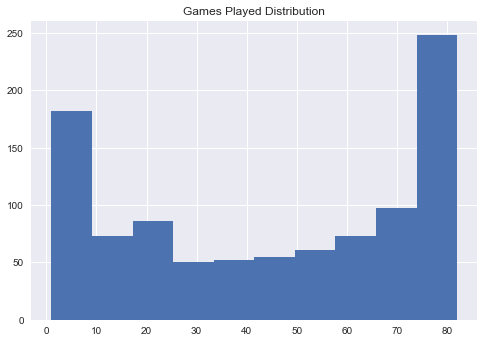

In [1058]:
dws = dw[dw['Position'] != 'G']
x1 = dws.GP 
plt.title('Games Played Distribution')
plt.hist(x1)
plt.show()

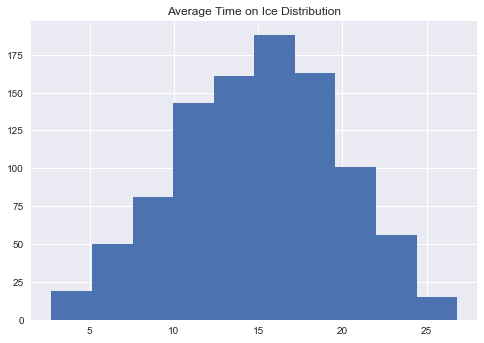

In [1059]:
x2 = dws.ATOI 
plt.title('Average Time on Ice Distribution')
plt.hist(x2)
plt.show()

In [1061]:
dws = dws[dws['GP'] > 9]
dws = dws.sort_values(['ATOI', 'TOI'], ascending=[True, True])
dws.head()

,Season,TeamCode,PlayerNumber,PlayerName,Position,GP,Goals,Assists,Points,GoalsF,GoalsA,Plus/Minus,Shots,ShotsA,Blocks,Hits,Faceoffs,Misses,Penalties,Giveaways,Takeaways,TOI,ATOI
437,2010,NYI,14.0,GILLIES,W,34,2,0,2,5.0,8.0,-3.0,9,87.0,6,44,0,4,34,1,1,119.69,3.07
157,2010,EDM,33.0,MACINTYRE,W,25,0,1,1,2.0,3.0,-1.0,6,60.0,4,23,0,2,24,7,1,120.20,3.54
597,2010,NSH,3.0,BELAK,W,15,0,0,0,0.0,1.0,-1.0,4,35.0,2,20,0,1,6,5,0,56.66,3.78
945,2010,OTT,49.0,LESSARD,W,22,0,0,0,1.0,1.0,0.0,6,30.0,2,36,1,4,14,2,1,92.54,3.86
798,2010,COL,28.0,KOCI,W,28,1,0,1,3.0,8.0,-5.0,9,92.0,5,28,0,1,16,1,1,143.09,4.09


In [1062]:
dws.to_csv('/Users/stefanostselios/Brock University/Kevin Mongeon - StephanosShare/out/clusters/stats_skaters.csv', index='False', sep=',')
#dws.to_csv('/Users/kevinmongeon/Brock University/Steve Tselios - StephanosShare/out/clusters/stats_skaters.csv', index='False', sep=',')

## Total stats for forwards

In [1209]:
#dww = dws[(dws['Position'] != 'C') & (dws['Position'] != 'D')]
dcw = dws[(dws['Position'] != 'D')]
dcw = dcw.sort_values(['GP', 'TOI'], ascending=[True, True])
dcw.head()

,Season,TeamCode,PlayerNumber,PlayerName,Position,GP,Goals,Assists,Points,GoalsF,GoalsA,Plus/Minus,Shots,ShotsA,Blocks,Hits,Faceoffs,Misses,Penalties,Giveaways,Takeaways,TOI,ATOI
878,2010,NYR,45.0,NEWBURY,W,10,0,1,1,1.0,2.0,-1.0,6,44.0,1,19,34,4,9,0,0,83.97,7.63
714,2010,ANA,51.0,PALMIERI,W,10,1,0,1,2.0,3.0,-1.0,10,43.0,1,5,0,3,0,1,0,86.87,8.69
13,2010,MTL,17.0,BOYD,C,10,1,0,1,1.0,7.0,-6.0,8,62.0,6,12,23,5,1,2,0,98.37,9.84
844,2010,PHX,39.0,MACLEAN,W,10,2,1,3,5.0,4.0,1.0,16,47.0,0,8,1,6,1,1,1,113.93,8.76
479,2010,STL,57.0,PERRON,W,10,5,2,7,8.0,2.0,6.0,29,66.0,1,6,0,5,6,3,9,184.18,18.42


In [1210]:
dcw.shape

(521, 23)

In [1211]:
f= dcw.copy()
f['Count'] = f.apply(lambda x: 1 if (x['PlayerName'] == x['PlayerName']) else 0, axis=1)
f['Player'] = f.groupby('PlayerName')['Count'].transform('sum')
f = f[f['Player'] > 1]

In [1212]:
# exclude players that have the same name but are different individuals
f = f[(f['PlayerName'] != 'JONES') & (f['PlayerName'] != 'BROWN') & (f['PlayerName'] != 'DUPUIS') & (f['PlayerName'] != 'GIONTA') & (f['PlayerName'] != 'HALL') & (f['PlayerName'] != 'JOKINEN') & (f['PlayerName'] != 'MITCHELL') & (f['PlayerName'] != 'OREILLY') & (f['PlayerName'] != 'PALMIERI') & (f['PlayerName'] != 'PORTER')& (f['PlayerName'] != 'PYATT') & (f['PlayerName'] != 'RICHARDS') & (f['PlayerName'] != 'SEDIN') & (f['PlayerName'] != 'STAAL') & (f['PlayerName'] != 'THORNTON') & (f['PlayerName'] != 'WHITE') & (f['PlayerName'] != 'WILSON') & (f['PlayerName'] != 'WILLIAMS') & (f['PlayerName'] != 'KANE') & (f['PlayerName'] != 'KOIVU') & (f['PlayerName'] != 'KOSTITSYN')] 

# total games played for the season
f['TGP'] = f.apply(lambda x: 0 if ((x['PlayerName'] == 'CARTER') & (x['TeamCode'] == 'PHI')) else 0 if ((x['PlayerName'] == 'RUUTU') & (x['TeamCode'] == 'CAR')) else 0 if ((x['PlayerName'] == 'STEWART') & (x['TeamCode'] == 'ATL')) else 0 if (x['PlayerName'] == 'WINCHESTER') & (x['TeamCode'] == 'OTT') else x['GP'], axis=1)
f['TGP'] = f.groupby('PlayerName')['TGP'].transform('sum')
f['TGP'] = f.apply(lambda x: x['GP'] if ((x['PlayerName'] == 'CARTER') & (x['TeamCode'] == 'PHI')) else x['GP'] if ((x['PlayerName'] == 'RUUTU') & (x['TeamCode'] == 'CAR')) else x['GP'] if ((x['PlayerName'] == 'STEWART') & (x['TeamCode'] == 'ATL')) else x['GP'] if (x['PlayerName'] == 'WINCHESTER') & (x['TeamCode'] == 'OTT') else x['TGP'], axis=1)

# total points for the season
f['TPoints'] = f.apply(lambda x: 0 if ((x['PlayerName'] == 'CARTER') & (x['TeamCode'] == 'PHI')) else 0 if ((x['PlayerName'] == 'RUUTU') & (x['TeamCode'] == 'CAR')) else 0 if ((x['PlayerName'] == 'STEWART') & (x['TeamCode'] == 'ATL')) else 0 if (x['PlayerName'] == 'WINCHESTER') & (x['TeamCode'] == 'OTT') else x['Points'], axis=1)
f['TPoints'] = f.groupby('PlayerName')['TPoints'].transform('sum')
f['TPoints'] = f.apply(lambda x: x['Points'] if ((x['PlayerName'] == 'CARTER') & (x['TeamCode'] == 'PHI')) else x['Points'] if ((x['PlayerName'] == 'RUUTU') & (x['TeamCode'] == 'CAR')) else x['Points'] if ((x['PlayerName'] == 'STEWART') & (x['TeamCode'] == 'ATL')) else x['Points'] if (x['PlayerName'] == 'WINCHESTER') & (x['TeamCode'] == 'OTT') else x['TPoints'], axis=1)

# total goals for the season
f['TGoals'] = f.apply(lambda x: 0 if ((x['PlayerName'] == 'CARTER') & (x['TeamCode'] == 'PHI')) else 0 if ((x['PlayerName'] == 'RUUTU') & (x['TeamCode'] == 'CAR')) else 0 if ((x['PlayerName'] == 'STEWART') & (x['TeamCode'] == 'ATL')) else 0 if (x['PlayerName'] == 'WINCHESTER') & (x['TeamCode'] == 'OTT') else x['Goals'], axis=1)
f['TGoals'] = f.groupby('PlayerName')['TGoals'].transform('sum')
f['TGoals'] = f.apply(lambda x: x['Goals'] if ((x['PlayerName'] == 'CARTER') & (x['TeamCode'] == 'PHI')) else x['Goals'] if ((x['PlayerName'] == 'RUUTU') & (x['TeamCode'] == 'CAR')) else x['Goals'] if ((x['PlayerName'] == 'STEWART') & (x['TeamCode'] == 'ATL')) else x['Goals'] if (x['PlayerName'] == 'WINCHESTER') & (x['TeamCode'] == 'OTT') else x['TGoals'], axis=1)

# total assists for the season
f['TAssists'] = f.apply(lambda x: 0 if ((x['PlayerName'] == 'CARTER') & (x['TeamCode'] == 'PHI')) else 0 if ((x['PlayerName'] == 'RUUTU') & (x['TeamCode'] == 'CAR')) else 0 if ((x['PlayerName'] == 'STEWART') & (x['TeamCode'] == 'ATL')) else 0 if (x['PlayerName'] == 'WINCHESTER') & (x['TeamCode'] == 'OTT') else x['Assists'], axis=1)
f['TAssists'] = f.groupby('PlayerName')['TAssists'].transform('sum')
f['TAssists'] = f.apply(lambda x: x['Assists'] if ((x['PlayerName'] == 'CARTER') & (x['TeamCode'] == 'PHI')) else x['Assists'] if ((x['PlayerName'] == 'RUUTU') & (x['TeamCode'] == 'CAR')) else x['Assists'] if ((x['PlayerName'] == 'STEWART') & (x['TeamCode'] == 'ATL')) else x['Assists'] if (x['PlayerName'] == 'WINCHESTER') & (x['TeamCode'] == 'OTT') else x['TAssists'], axis=1)

# total goals on ice for the season
f['TGoalsF'] = f.apply(lambda x: 0 if ((x['PlayerName'] == 'CARTER') & (x['TeamCode'] == 'PHI')) else 0 if ((x['PlayerName'] == 'RUUTU') & (x['TeamCode'] == 'CAR')) else 0 if ((x['PlayerName'] == 'STEWART') & (x['TeamCode'] == 'ATL')) else 0 if (x['PlayerName'] == 'WINCHESTER') & (x['TeamCode'] == 'OTT') else x['GoalsF'], axis=1)
f['TGoalsF'] = f.groupby('PlayerName')['TGoalsF'].transform('sum')
f['TGoalsF'] = f.apply(lambda x: x['GoalsF'] if ((x['PlayerName'] == 'CARTER') & (x['TeamCode'] == 'PHI')) else x['GoalsF'] if ((x['PlayerName'] == 'RUUTU') & (x['TeamCode'] == 'CAR')) else x['GoalsF'] if ((x['PlayerName'] == 'STEWART') & (x['TeamCode'] == 'ATL')) else x['GoalsF'] if (x['PlayerName'] == 'WINCHESTER') & (x['TeamCode'] == 'OTT') else x['TGoalsF'], axis=1)

# total goals on ice against for the season
f['TGoalsA'] = f.apply(lambda x: 0 if ((x['PlayerName'] == 'CARTER') & (x['TeamCode'] == 'PHI')) else 0 if ((x['PlayerName'] == 'RUUTU') & (x['TeamCode'] == 'CAR')) else 0 if ((x['PlayerName'] == 'STEWART') & (x['TeamCode'] == 'ATL')) else 0 if (x['PlayerName'] == 'WINCHESTER') & (x['TeamCode'] == 'OTT') else x['GoalsA'], axis=1)
f['TGoalsA'] = f.groupby('PlayerName')['TGoals'].transform('sum')
f['TGoalsA'] = f.apply(lambda x: x['GoalsA'] if ((x['PlayerName'] == 'CARTER') & (x['TeamCode'] == 'PHI')) else x['GoalsA'] if ((x['PlayerName'] == 'RUUTU') & (x['TeamCode'] == 'CAR')) else x['GoalsA'] if ((x['PlayerName'] == 'STEWART') & (x['TeamCode'] == 'ATL')) else x['GoalsA'] if (x['PlayerName'] == 'WINCHESTER') & (x['TeamCode'] == 'OTT') else x['TGoalsA'], axis=1)

# total plus/minus for the season
f['TPlus/Minus'] = f.apply(lambda x: 0 if ((x['PlayerName'] == 'CARTER') & (x['TeamCode'] == 'PHI')) else 0 if ((x['PlayerName'] == 'RUUTU') & (x['TeamCode'] == 'CAR')) else 0 if ((x['PlayerName'] == 'STEWART') & (x['TeamCode'] == 'ATL')) else 0 if (x['PlayerName'] == 'WINCHESTER') & (x['TeamCode'] == 'OTT') else x['Plus/Minus'], axis=1)
f['TPlus/Minus'] = f.groupby('PlayerName')['TPlus/Minus'].transform('sum')
f['TPlus/Minus'] = f.apply(lambda x: x['Plus/Minus'] if ((x['PlayerName'] == 'CARTER') & (x['TeamCode'] == 'PHI')) else x['Plus/Minus'] if ((x['PlayerName'] == 'RUUTU') & (x['TeamCode'] == 'CAR')) else x['Plus/Minus'] if ((x['PlayerName'] == 'STEWART') & (x['TeamCode'] == 'ATL')) else x['Plus/Minus'] if (x['PlayerName'] == 'WINCHESTER') & (x['TeamCode'] == 'OTT') else x['TPlus/Minus'], axis=1)

# total shots for the season
f['TShots'] = f.apply(lambda x: 0 if ((x['PlayerName'] == 'CARTER') & (x['TeamCode'] == 'PHI')) else 0 if ((x['PlayerName'] == 'RUUTU') & (x['TeamCode'] == 'CAR')) else 0 if ((x['PlayerName'] == 'STEWART') & (x['TeamCode'] == 'ATL')) else 0 if (x['PlayerName'] == 'WINCHESTER') & (x['TeamCode'] == 'OTT') else x['Shots'], axis=1)
f['TShots'] = f.groupby('PlayerName')['TShots'].transform('sum')
f['TShots'] = f.apply(lambda x: x['Shots'] if ((x['PlayerName'] == 'CARTER') & (x['TeamCode'] == 'PHI')) else x['Shots'] if ((x['PlayerName'] == 'RUUTU') & (x['TeamCode'] == 'CAR')) else x['Shots'] if ((x['PlayerName'] == 'STEWART') & (x['TeamCode'] == 'ATL')) else x['Shots'] if (x['PlayerName'] == 'WINCHESTER') & (x['TeamCode'] == 'OTT') else x['TShots'], axis=1)

# total shots against for the season
f['TShotsA'] = f.apply(lambda x: 0 if ((x['PlayerName'] == 'CARTER') & (x['TeamCode'] == 'PHI')) else 0 if ((x['PlayerName'] == 'RUUTU') & (x['TeamCode'] == 'CAR')) else 0 if ((x['PlayerName'] == 'STEWART') & (x['TeamCode'] == 'ATL')) else 0 if (x['PlayerName'] == 'WINCHESTER') & (x['TeamCode'] == 'OTT') else x['ShotsA'], axis=1)
f['TShotsA'] = f.groupby('PlayerName')['TShotsA'].transform('sum')
f['TShotsA'] = f.apply(lambda x: x['ShotsA'] if ((x['PlayerName'] == 'CARTER') & (x['TeamCode'] == 'PHI')) else x['ShotsA'] if ((x['PlayerName'] == 'RUUTU') & (x['TeamCode'] == 'CAR')) else x['ShotsA'] if ((x['PlayerName'] == 'STEWART') & (x['TeamCode'] == 'ATL')) else x['ShotsA'] if (x['PlayerName'] == 'WINCHESTER') & (x['TeamCode'] == 'OTT') else x['TShotsA'], axis=1)

# total blocks for the season
f['TBlocks'] = f.apply(lambda x: 0 if ((x['PlayerName'] == 'CARTER') & (x['TeamCode'] == 'PHI')) else 0 if ((x['PlayerName'] == 'RUUTU') & (x['TeamCode'] == 'CAR')) else 0 if ((x['PlayerName'] == 'STEWART') & (x['TeamCode'] == 'ATL')) else 0 if (x['PlayerName'] == 'WINCHESTER') & (x['TeamCode'] == 'OTT') else x['Blocks'], axis=1)
f['TBlocks'] = f.groupby('PlayerName')['TBlocks'].transform('sum')
f['TBlocks'] = f.apply(lambda x: x['Blocks'] if ((x['PlayerName'] == 'CARTER') & (x['TeamCode'] == 'PHI')) else x['Blocks'] if ((x['PlayerName'] == 'RUUTU') & (x['TeamCode'] == 'CAR')) else x['Blocks'] if ((x['PlayerName'] == 'STEWART') & (x['TeamCode'] == 'ATL')) else x['Blocks'] if (x['PlayerName'] == 'WINCHESTER') & (x['TeamCode'] == 'OTT') else x['TBlocks'], axis=1)

# total hits for the season
f['THits'] = f.apply(lambda x: 0 if ((x['PlayerName'] == 'CARTER') & (x['TeamCode'] == 'PHI')) else 0 if ((x['PlayerName'] == 'RUUTU') & (x['TeamCode'] == 'CAR')) else 0 if ((x['PlayerName'] == 'STEWART') & (x['TeamCode'] == 'ATL')) else 0 if (x['PlayerName'] == 'WINCHESTER') & (x['TeamCode'] == 'OTT') else x['Hits'], axis=1)
f['THits'] = f.groupby('PlayerName')['THits'].transform('sum')
f['THits'] = f.apply(lambda x: x['Hits'] if ((x['PlayerName'] == 'CARTER') & (x['TeamCode'] == 'PHI')) else x['Hits'] if ((x['PlayerName'] == 'RUUTU') & (x['TeamCode'] == 'CAR')) else x['Hits'] if ((x['PlayerName'] == 'STEWART') & (x['TeamCode'] == 'ATL')) else x['Hits'] if (x['PlayerName'] == 'WINCHESTER') & (x['TeamCode'] == 'OTT') else x['THits'], axis=1)

# total faceoffs for the season
f['TFaceoffs'] = f.apply(lambda x: 0 if ((x['PlayerName'] == 'CARTER') & (x['TeamCode'] == 'PHI')) else 0 if ((x['PlayerName'] == 'RUUTU') & (x['TeamCode'] == 'CAR')) else 0 if ((x['PlayerName'] == 'STEWART') & (x['TeamCode'] == 'ATL')) else 0 if (x['PlayerName'] == 'WINCHESTER') & (x['TeamCode'] == 'OTT') else x['Faceoffs'], axis=1)
f['TFaceoffs'] = f.groupby('PlayerName')['TFaceoffs'].transform('sum')
f['TFaceoffs'] = f.apply(lambda x: x['Faceoffs'] if ((x['PlayerName'] == 'CARTER') & (x['TeamCode'] == 'PHI')) else x['Faceoffs'] if ((x['PlayerName'] == 'RUUTU') & (x['TeamCode'] == 'CAR')) else x['Faceoffs'] if ((x['PlayerName'] == 'STEWART') & (x['TeamCode'] == 'ATL')) else x['Faceoffs'] if (x['PlayerName'] == 'WINCHESTER') & (x['TFaceoffs'] == 'OTT') else x['TFaceoffs'], axis=1)

# total miss shots for the season
f['TMisses'] = f.apply(lambda x: 0 if ((x['PlayerName'] == 'CARTER') & (x['TeamCode'] == 'PHI')) else 0 if ((x['PlayerName'] == 'RUUTU') & (x['TeamCode'] == 'CAR')) else 0 if ((x['PlayerName'] == 'STEWART') & (x['TeamCode'] == 'ATL')) else 0 if (x['PlayerName'] == 'WINCHESTER') & (x['TeamCode'] == 'OTT') else x['Misses'], axis=1)
f['TMisses'] = f.groupby('PlayerName')['TMisses'].transform('sum')
f['TMisses'] = f.apply(lambda x: x['Misses'] if ((x['PlayerName'] == 'CARTER') & (x['TeamCode'] == 'PHI')) else x['Misses'] if ((x['PlayerName'] == 'RUUTU') & (x['TeamCode'] == 'CAR')) else x['Misses'] if ((x['PlayerName'] == 'STEWART') & (x['TeamCode'] == 'ATL')) else x['Misses'] if (x['PlayerName'] == 'WINCHESTER') & (x['TeamCode'] == 'OTT') else x['TMisses'], axis=1)

# total penalties for the season
f['TPenalties'] = f.apply(lambda x: 0 if ((x['PlayerName'] == 'CARTER') & (x['TeamCode'] == 'PHI')) else 0 if ((x['PlayerName'] == 'RUUTU') & (x['TeamCode'] == 'CAR')) else 0 if ((x['PlayerName'] == 'STEWART') & (x['TeamCode'] == 'ATL')) else 0 if (x['PlayerName'] == 'WINCHESTER') & (x['TeamCode'] == 'OTT') else x['Penalties'], axis=1)
f['TPenalties'] = f.groupby('PlayerName')['TPenalties'].transform('sum')
f['TPenalties'] = f.apply(lambda x: x['Penalties'] if ((x['PlayerName'] == 'CARTER') & (x['TeamCode'] == 'PHI')) else x['Penalties'] if ((x['PlayerName'] == 'RUUTU') & (x['TeamCode'] == 'CAR')) else x['Penalties'] if ((x['PlayerName'] == 'STEWART') & (x['TeamCode'] == 'ATL')) else x['Penalties'] if (x['PlayerName'] == 'WINCHESTER') & (x['TeamCode'] == 'OTT') else x['TPenalties'], axis=1)

# total giveaways for the season
f['TGiveaways'] = f.apply(lambda x: 0 if ((x['PlayerName'] == 'CARTER') & (x['TeamCode'] == 'PHI')) else 0 if ((x['PlayerName'] == 'RUUTU') & (x['TeamCode'] == 'CAR')) else 0 if ((x['PlayerName'] == 'STEWART') & (x['TeamCode'] == 'ATL')) else 0 if (x['PlayerName'] == 'WINCHESTER') & (x['TeamCode'] == 'OTT') else x['Giveaways'], axis=1)
f['TGiveaways'] = f.groupby('PlayerName')['TGiveaways'].transform('sum')
f['TGiveaways'] = f.apply(lambda x: x['Giveaways'] if ((x['PlayerName'] == 'CARTER') & (x['TeamCode'] == 'PHI')) else x['Giveaways'] if ((x['PlayerName'] == 'RUUTU') & (x['TeamCode'] == 'CAR')) else x['Giveaways'] if ((x['PlayerName'] == 'STEWART') & (x['TeamCode'] == 'ATL')) else x['Giveaways'] if (x['PlayerName'] == 'WINCHESTER') & (x['TeamCode'] == 'OTT') else x['TGiveaways'], axis=1)

# total takeaways for the season
f['TTakeaways'] = f.apply(lambda x: 0 if ((x['PlayerName'] == 'CARTER') & (x['TeamCode'] == 'PHI')) else 0 if ((x['PlayerName'] == 'RUUTU') & (x['TeamCode'] == 'CAR')) else 0 if ((x['PlayerName'] == 'STEWART') & (x['TeamCode'] == 'ATL')) else 0 if (x['PlayerName'] == 'WINCHESTER') & (x['TeamCode'] == 'OTT') else x['Takeaways'], axis=1)
f['TTakeaways'] = f.groupby('PlayerName')['TTakeaways'].transform('sum')
f['TTakeaways'] = f.apply(lambda x: x['Takeaways'] if ((x['PlayerName'] == 'CARTER') & (x['TeamCode'] == 'PHI')) else x['Takeaways'] if ((x['PlayerName'] == 'RUUTU') & (x['TeamCode'] == 'CAR')) else x['Takeaways'] if ((x['PlayerName'] == 'STEWART') & (x['TeamCode'] == 'ATL')) else x['Takeaways'] if (x['PlayerName'] == 'WINCHESTER') & (x['TeamCode'] == 'OTT') else x['TTakeaways'], axis=1)

# time on ice for the season
f['TTOI'] = f.apply(lambda x: 0 if ((x['PlayerName'] == 'CARTER') & (x['TeamCode'] == 'PHI')) else 0 if ((x['PlayerName'] == 'RUUTU') & (x['TeamCode'] == 'CAR')) else 0 if ((x['PlayerName'] == 'STEWART') & (x['TeamCode'] == 'ATL')) else 0 if (x['PlayerName'] == 'WINCHESTER') & (x['TeamCode'] == 'OTT') else x['TOI'], axis=1)
f['TTOI'] = f.groupby('PlayerName')['TTOI'].transform('sum')
f['TTOI'] = f.apply(lambda x: x['TOI'] if ((x['PlayerName'] == 'CARTER') & (x['TeamCode'] == 'PHI')) else x['TOI'] if ((x['PlayerName'] == 'RUUTU') & (x['TeamCode'] == 'CAR')) else x['TOI'] if ((x['PlayerName'] == 'STEWART') & (x['TeamCode'] == 'ATL')) else x['TOI'] if (x['PlayerName'] == 'WINCHESTER') & (x['TeamCode'] == 'OTT') else x['TTOI'], axis=1)

In [1213]:
dfs = pd.merge(dcw, f, on=['Season', 'TeamCode', 'PlayerNumber', 'PlayerName', 'Position', 'GP', 'Goals', 'Assists', 'Points', 'GoalsF', 'GoalsA', 'Plus/Minus', 'Shots', 'ShotsA', 'Blocks', 'Hits', 'Faceoffs', 'Misses', 'Penalties', 'Giveaways', 'Takeaways', 'TOI', 'ATOI'], how='left')

In [1214]:
dfs.shape

(521, 42)

In [1215]:
dfs['TGP'] = dfs.apply(lambda x: x['GP'] if pd.isnull(x['TGP']) else x['TGP'], axis=1)

dfs['TPoints'] = dfs.apply(lambda x: x['Points'] if pd.isnull(x['TPoints']) else x['TPoints'], axis=1)
dfs['TGoals'] = dfs.apply(lambda x: x['Goals'] if pd.isnull(x['TGoals']) else x['TGoals'], axis=1)
dfs['TAssists'] = dfs.apply(lambda x: x['Assists'] if pd.isnull(x['TAssists']) else x['TAssists'], axis=1)

dfs['TGoalsF'] = dfs.apply(lambda x: x['GoalsF'] if pd.isnull(x['TGoalsF']) else x['TGoalsF'], axis=1)
dfs['TGoalsA'] = dfs.apply(lambda x: x['GoalsA'] if pd.isnull(x['TGoalsA']) else x['TGoalsA'], axis=1)
dfs['TPlus/Minus'] = dfs.apply(lambda x: x['Plus/Minus'] if pd.isnull(x['TPlus/Minus']) else x['TPlus/Minus'], axis=1)

dfs['TShots'] = dfs.apply(lambda x: x['Shots'] if pd.isnull(x['TShots']) else x['TShots'], axis=1)
dfs['TShotsA'] = dfs.apply(lambda x: x['ShotsA'] if pd.isnull(x['TShotsA']) else x['TShotsA'], axis=1)
dfs['TMisses'] = dfs.apply(lambda x: x['Misses'] if pd.isnull(x['TMisses']) else x['TMisses'], axis=1)

dfs['TBlocks'] = dfs.apply(lambda x: x['Blocks'] if pd.isnull(x['TBlocks']) else x['TBlocks'], axis=1)
dfs['THits'] = dfs.apply(lambda x: x['Hits'] if pd.isnull(x['THits']) else x['THits'], axis=1)

dfs['TFaceoffs'] = dfs.apply(lambda x: x['Faceoffs'] if pd.isnull(x['TFaceoffs']) else x['TFaceoffs'], axis=1)
dfs['TPenalties'] = dfs.apply(lambda x: x['Penalties'] if pd.isnull(x['TPenalties']) else x['TPenalties'], axis=1)

dfs['TGiveaways'] = dfs.apply(lambda x: x['Giveaways'] if pd.isnull(x['TGiveaways']) else x['TGiveaways'], axis=1)
dfs['TTakeaways'] = dfs.apply(lambda x: x['Takeaways'] if pd.isnull(x['TTakeaways']) else x['TTakeaways'], axis=1)

dfs['TTOI'] = dfs.apply(lambda x: x['TOI'] if pd.isnull(x['TTOI']) else x['TTOI'], axis=1)

In [1216]:
dfs['TOIPoints'] = dfs['TPoints']/dfs['TTOI']
dfs['TOIGoals'] = dfs['TGoals']/dfs['TTOI']
dfs['TOIAssists'] = dfs['TAssists']/dfs['TTOI']

dfs['TOIGoalsF'] = dfs['TGoalsF']/dfs['TTOI']
dfs['TOIGoalsA'] = dfs['TGoalsA']/dfs['TTOI']
dfs['TOIPlus/Minus'] = dfs['TPlus/Minus']/dfs['TTOI']

dfs['TOIShots'] = dfs['TShots']/dfs['TTOI']
dfs['TOIShotsA'] = dfs['TShotsA']/dfs['TTOI']
dfs['ShotRatio'] = dfs['TShots']/ dfs['TShotsA']
dfs['TOIMisses'] = dfs['TMisses']/dfs['TTOI']

dfs['TOIBlocks'] = dfs['TBlocks']/dfs['TTOI']
dfs['TOIHits'] = dfs['THits']/dfs['TTOI']

dfs['TOIFaceoffs'] = dfs['TFaceoffs']/dfs['TTOI']
dfs['TOIPenalties'] = dfs['TPenalties']/dfs['TTOI']

dfs['TOIGiveaways'] = dfs['TGiveaways']/dfs['TGP']
dfs['TOITakeaways'] = dfs['TTakeaways']/dfs['TTOI']

dfs['TATOI'] = dfs['TTOI']/dfs['TGP']

In [1217]:
dfs = dfs[['Season', 'TeamCode', 'PlayerNumber', 'PlayerName', 'Position', 'GP', 'Goals', 'Assists', 'Points', 'GoalsF', 'GoalsA', 'Plus/Minus', 'Shots', 'ShotsA','ShotRatio', 'Blocks', 'Hits', 'Faceoffs', 'Misses', 'Penalties', 'Giveaways', 'Takeaways', 'TOI', 'ATOI', 'TGP', 'TPoints', 'TGoals', 'TAssists', 'TGoalsF', 'TGoalsA', 'TPlus/Minus', 'TShots', 'TShotsA', 'TBlocks', 'THits', 'TFaceoffs', 'TMisses', 'TPenalties', 'TGiveaways', 'TTakeaways', 'TTOI', 'TOIPoints', 'TOIGoals', 'TOIAssists', 'TOIGoalsF', 'TOIGoalsA', 'TOIPlus/Minus', 'TOIShots', 'TOIShotsA', 'TOIMisses', 'TOIBlocks', 'TOIHits', 'TOIFaceoffs', 'TOIPenalties', 'TOIGiveaways', 'TOITakeaways', 'TATOI']]

In [1218]:
dfs.to_csv('/Users/stefanostselios/Brock University/Kevin Mongeon - StephanosShare/out/clusters/total_stats_forwards.csv', index='False', sep=',')
#dfs.to_csv('/Users/kevinmongeon/Brock University/Steve Tselios - StephanosShare/out/clusters/total_stats_forwards.csv', index='False', sep=',')

## clusters for centers

In [1219]:
dwc = dfs[(dfs['Position'] == 'C')]
dwc.shape

(165, 57)

### standardization

- It is important to standardize the data so that we can effectively compare player performance. 
- Scale on-ice events per minute for each player relative to the league's season minimum and maximumn performance. All on-ice events per minute will have values between 0 and 1. 
- This technique makes sure that no particular event is being overweighted.

In [2026]:
dwc = dwc.sort_values(['TPoints'], ascending=[False])
dwc.head()

,Season,TeamCode,PlayerNumber,PlayerName,Position,GP,Goals,Assists,Points,GoalsF,GoalsA,Plus/Minus,Shots,ShotsA,ShotRatio,Blocks,Hits,Faceoffs,Misses,Penalties,Giveaways,Takeaways,TOI,ATOI,TGP,TPoints,TGoals,TAssists,TGoalsF,TGoalsA,TPlus/Minus,TShots,TShotsA,TBlocks,THits,TFaceoffs,TMisses,TPenalties,TGiveaways,TTakeaways,TTOI,TOIPoints,TOIGoals,TOIAssists,TOIGoalsF,TOIGoalsA,TOIPlus/Minus,TOIShots,TOIShotsA,TOIMisses,TOIBlocks,TOIHits,TOIFaceoffs,TOIPenalties,TOIGiveaways,TOITakeaways,TATOI,cluster,Rank
505,2010,VAN,33.0,SEDIN,C,82,19,75,94,77.0,49.0,28.0,157,650.0,0.241538,21,15,721,42,20,38,43,1579.22,19.26,82.0,94.0,19.0,75.0,77.0,49.0,28.0,157.0,650.0,21.0,15.0,721.0,42.0,20.0,38.0,43.0,1579.22,0.059523,0.012031,0.047492,0.048758,0.031028,0.017730,0.099416,0.411596,0.026595,0.013298,0.009498,0.456555,0.012664,0.463415,0.027229,19.258780,0,1
515,2010,TB,91.0,STAMKOS,C,82,45,47,92,71.0,55.0,16.0,272,730.0,0.372603,37,84,431,133,34,60,40,1655.35,20.19,82.0,92.0,45.0,47.0,71.0,55.0,16.0,272.0,730.0,37.0,84.0,431.0,133.0,34.0,60.0,40.0,1655.35,0.055577,0.027185,0.028393,0.042891,0.033226,0.009666,0.164316,0.440994,0.080346,0.022352,0.050745,0.260368,0.020539,0.731707,0.024164,20.187195,0,1
333,2010,DAL,91.0,RICHARDS,C,72,28,49,77,58.0,45.0,13.0,272,724.0,0.375691,22,20,501,122,8,73,47,1559.11,21.65,72.0,77.0,28.0,49.0,58.0,45.0,13.0,272.0,724.0,22.0,20.0,501.0,122.0,8.0,73.0,47.0,1559.11,0.049387,0.017959,0.031428,0.037201,0.028863,0.008338,0.174459,0.464367,0.078250,0.014111,0.012828,0.321337,0.005131,1.013889,0.030145,21.654306,0,1
470,2010,CAR,12.0,STAAL,C,81,33,43,76,68.0,74.0,-6.0,296,941.0,0.314559,31,81,839,133,31,44,64,1783.15,22.01,81.0,76.0,33.0,43.0,68.0,74.0,-6.0,296.0,941.0,31.0,81.0,839.0,133.0,31.0,44.0,64.0,1783.15,0.042621,0.018507,0.024115,0.038135,0.041500,-0.003365,0.165998,0.527718,0.074587,0.017385,0.045425,0.470516,0.017385,0.543210,0.035892,22.014198,0,1
295,2010,ANA,15.0,GETZLAF,C,67,19,57,76,71.0,54.0,17.0,117,651.0,0.179724,57,189,542,65,16,81,35,1464.38,21.86,67.0,76.0,19.0,57.0,71.0,54.0,17.0,117.0,651.0,57.0,189.0,542.0,65.0,16.0,81.0,35.0,1464.38,0.051899,0.012975,0.038924,0.048485,0.036876,0.011609,0.079897,0.444557,0.044387,0.038924,0.129065,0.370123,0.010926,1.208955,0.023901,21.856418,0,1


In [2102]:
scaler = MinMaxScaler()
#scaler = StandardScaler()
x = dwc[['TPoints', 'TOIPoints', 'TOIGoals', 'TOIAssists', 'TOIPlus/Minus', 'TOIShots', 'TOIShotsA', 'TOIBlocks', 'TOITakeaways']]
x_scaled = scaler.fit_transform( x )

### dendrogram

- Dendogram shows the distance between any two observations in a dataset. The vertical axis determines the distance. The longer the axis, the larger the distance.
- The clustermap feature in seaborn provides the dendogram. It also displays the distance between observations as well as the features.

In [2103]:
cmap = sn.cubehelix_palette(as_cmap=True, rot=-.3, light=1)

In [2104]:
sn.clustermap(x_scaled, cmap=cmap, linewidths=.5)

/anaconda/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


### elbow analysis

- Elbow method is a method of interpretation and validation of consistency within cluster analysis designed to help finding the appropriate number of clusters in a dataset.
- Explained Variance: This method looks at the percentage of variance explained as a function of the number of clusters: One should choose a number of clusters so that adding another cluster doesn't give much better modeling of the data.
- if one plots the percentage of variance explained by the clusters against the number of clusters the first clusters will add much information (explain a lot of variance), but at some point the marginal gain in explained variance will drop, giving an angle in the graph. The number of clusters is chosen at this point, hence the "elbow criterion".

In [2105]:
cluster_range = range( 1, 20 )
cluster_errors = []

for num_clusters in cluster_range:
  clusters = KMeans( num_clusters )
  clusters.fit( x_scaled )
  cluster_errors.append( clusters.inertia_ )

In [2106]:
clusters_dwc = pd.DataFrame( { "num_clusters":cluster_range, "cluster_errors": cluster_errors } )

In [2107]:
clusters_dwc[0:10]

,cluster_errors,num_clusters
0,48.985465,1
1,32.002062,2
2,26.477188,3
3,23.883562,4
4,22.311835,5
5,20.848727,6
6,19.699167,7
7,18.605763,8
8,17.915387,9
9,16.931412,10


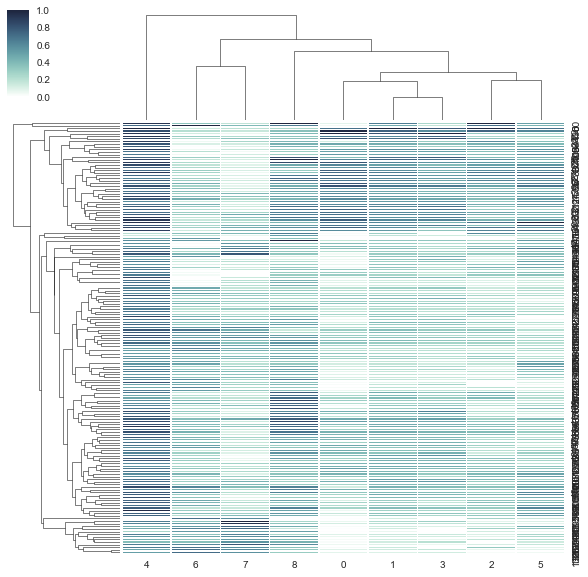

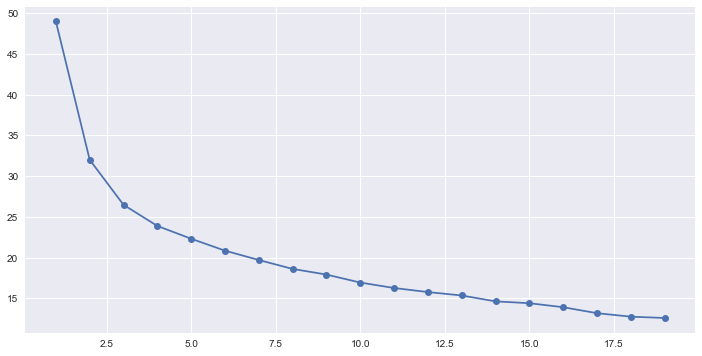

In [2108]:
plt.figure(figsize=(12,6))
plt.plot( clusters_dwc.num_clusters, clusters_dwc.cluster_errors, marker = "o" )
plt.show()

### silhouette analysis

- The silhouette value is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation).
- The silhouette ranges from -1 to 1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters.
- If most objects have a high value, then the clustering configuration is appropriate. If many points have a low or negative value, then the clustering configuration may have too many or too few clusters.
- The silhouette can be calculated with any distance metric, such as the Euclidean distance or the Manhattan distance.

Silhouette score of an observation is given by:
\begin{equation}
s(i)=\frac{b(i)−a(i)}{max[a(i),b(i)]}
\end{equation}

From the above definition it is clear that silhoutte score always lies between:

\begin{equation}
−1≤s(i)≤1−1≤s(i)≤1
\end{equation}
Score closer to 1 means assigned to the cluster correctly and score closer to -1 is assigned to a wrong cluster. A score close to 0 means the point lies between almost at the boundary of both the clusters.

For n_clusters = 2 The average silhouette_score is : 0.290347372455


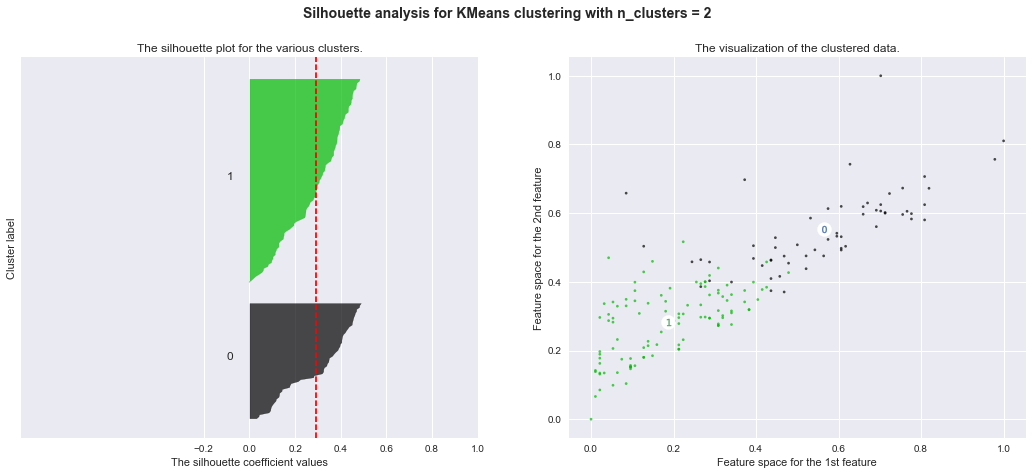

For n_clusters = 3 The average silhouette_score is : 0.210668229965


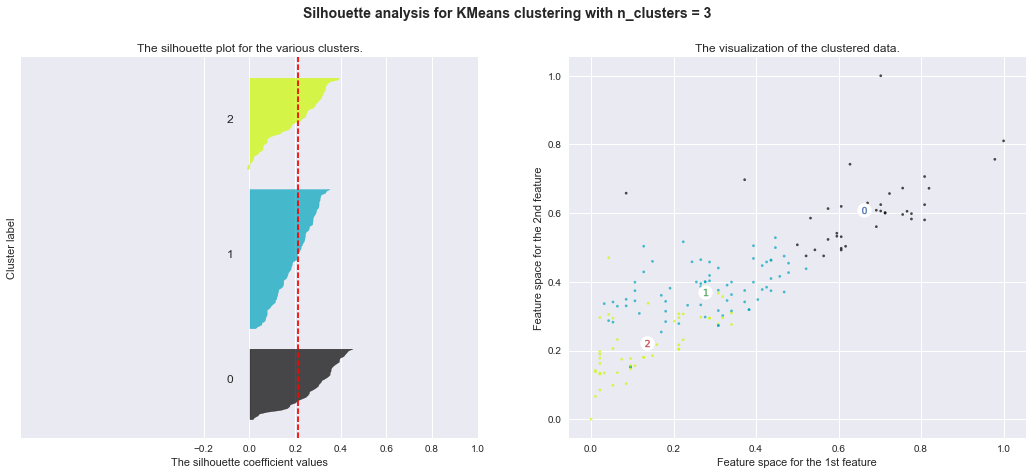

For n_clusters = 4 The average silhouette_score is : 0.192274125502


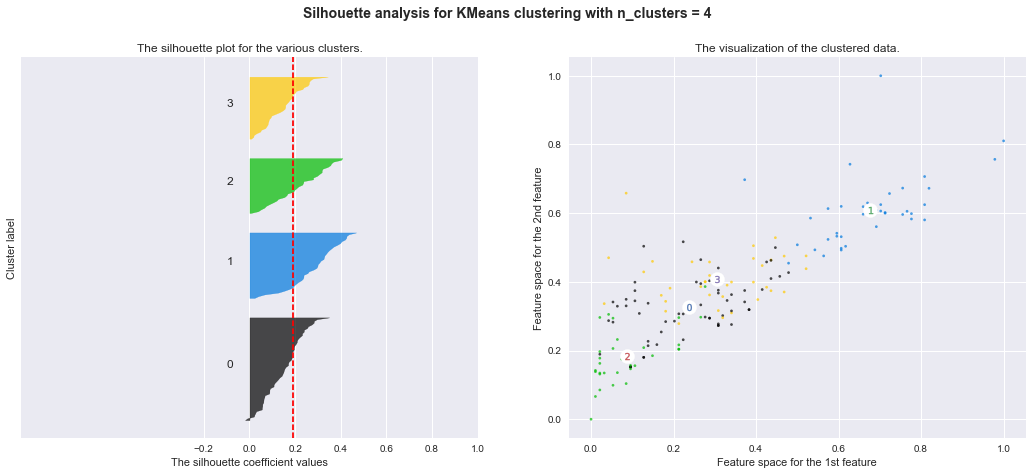

For n_clusters = 5 The average silhouette_score is : 0.169995504742


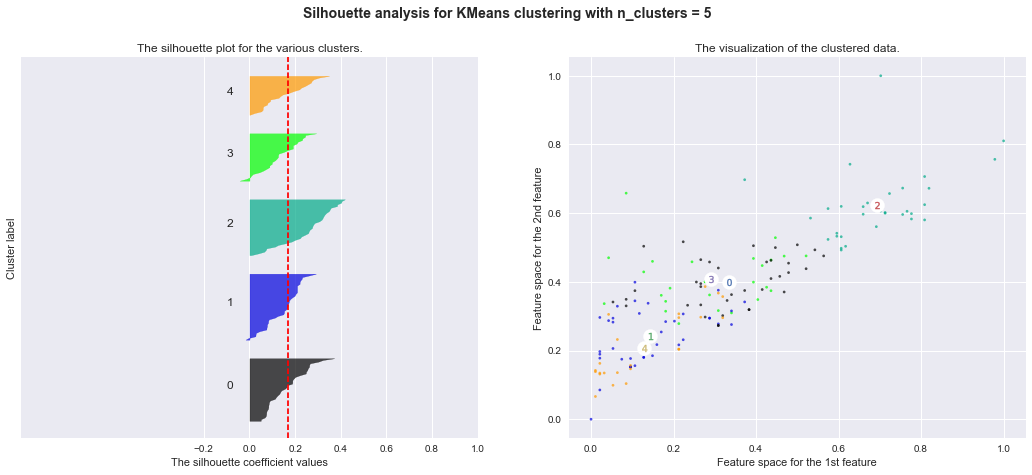

For n_clusters = 6 The average silhouette_score is : 0.14994656098


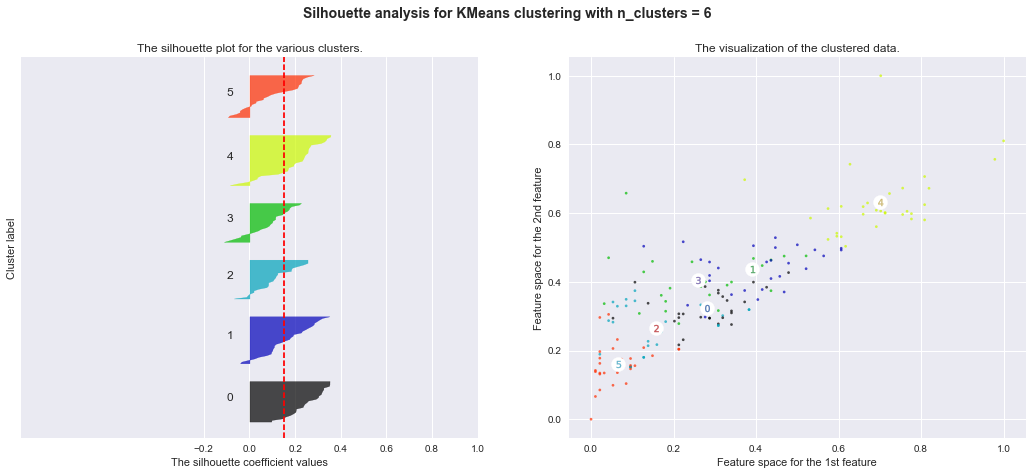

For n_clusters = 7 The average silhouette_score is : 0.154520837599


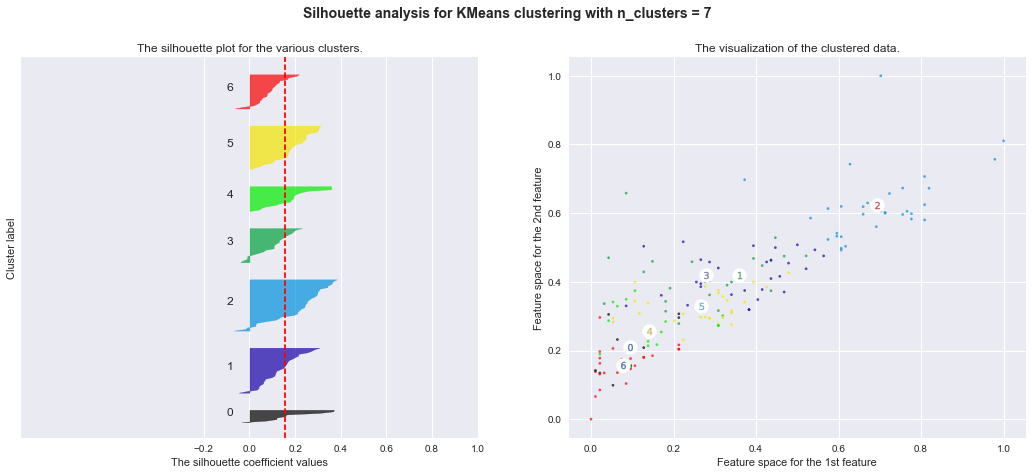

For n_clusters = 8 The average silhouette_score is : 0.15357770595


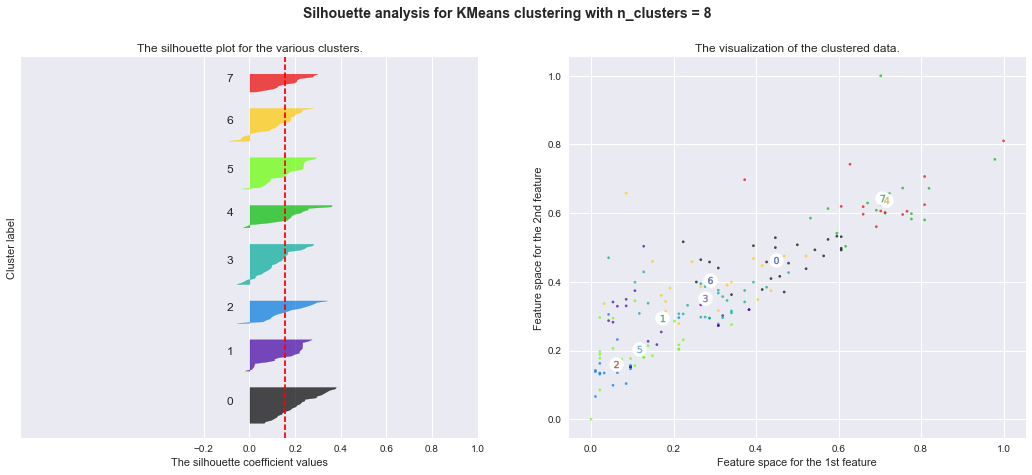

For n_clusters = 9 The average silhouette_score is : 0.156954513534


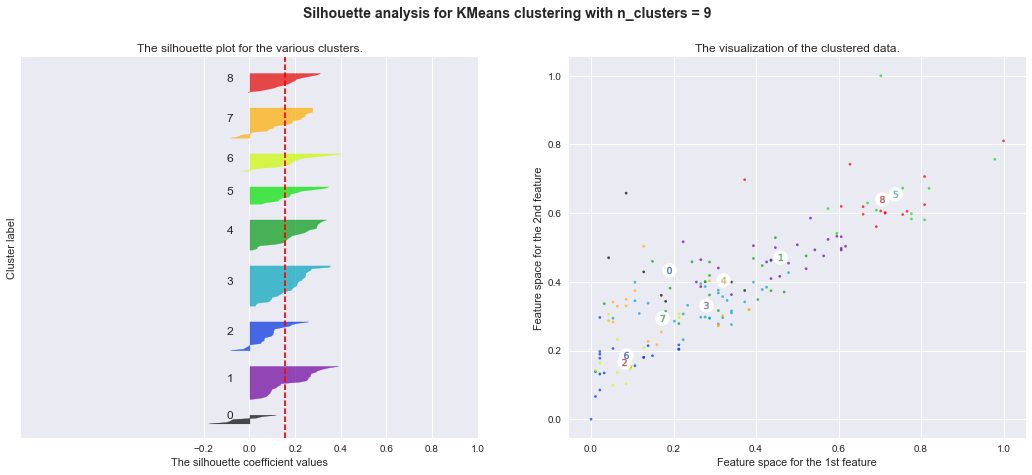

For n_clusters = 10 The average silhouette_score is : 0.143220139105


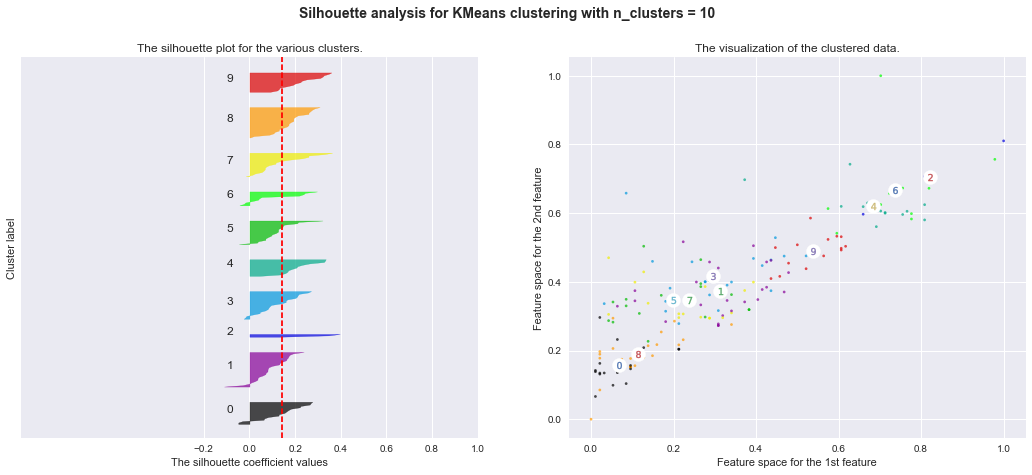

In [2109]:
cluster_range = range( 2, 11 )

for n_clusters in cluster_range:
  # Create a subplot with 1 row and 2 columns
  fig, (ax1, ax2) = plt.subplots(1, 2)
  fig.set_size_inches(18, 7)

  # The 1st subplot is the silhouette plot
  # The silhouette coefficient can range from -1, 1 but in this example all
  # lie within [-1, 1]
  ax1.set_xlim([-1, 1])
  # The (n_clusters+1)*10 is for inserting blank space between silhouette
  # plots of individual clusters, to demarcate them clearly.
  ax1.set_ylim([0, len(x_scaled) + (n_clusters + 1) * 10])

  # Initialize the clusterer with n_clusters value and a random generator
  # seed of 10 for reproducibility.
  clusterer = KMeans(n_clusters=n_clusters, max_iter=1000, random_state=10)
  cluster_labels = clusterer.fit_predict( x_scaled )

  # The silhouette_score gives the average value for all the samples.
  # This gives a perspective into the density and separation of the formed
  # clusters
  silhouette_avg = silhouette_score(x_scaled, cluster_labels)
  print("For n_clusters =", n_clusters,
        "The average silhouette_score is :", silhouette_avg)

  # Compute the silhouette scores for each sample
  sample_silhouette_values = silhouette_samples(x_scaled, cluster_labels)

  y_lower = 10
  for i in range(n_clusters):
      # Aggregate the silhouette scores for samples belonging to
      # cluster i, and sort them
      ith_cluster_silhouette_values = \
          sample_silhouette_values[cluster_labels == i]

      ith_cluster_silhouette_values.sort()

      size_cluster_i = ith_cluster_silhouette_values.shape[0]
      y_upper = y_lower + size_cluster_i

      color = cm.spectral(float(i) / n_clusters)
      ax1.fill_betweenx(np.arange(y_lower, y_upper),
                        0, ith_cluster_silhouette_values,
                        facecolor=color, edgecolor=color, alpha=0.7)

      # Label the silhouette plots with their cluster numbers at the middle
      ax1.text(-0.1, y_lower + 0.5 * size_cluster_i, str(i))

      # Compute the new y_lower for next plot
      y_lower = y_upper + 10  # 10 for the 0 samples

  ax1.set_title("The silhouette plot for the various clusters.")
  ax1.set_xlabel("The silhouette coefficient values")
  ax1.set_ylabel("Cluster label")

  # The vertical line for average silhoutte score of all the values
  ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

  ax1.set_yticks([])  # Clear the yaxis labels / ticks
  ax1.set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

  # 2nd Plot showing the actual clusters formed
  colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
  ax2.scatter(x_scaled[:, 0], x_scaled[:, 1], marker='.', s=30, lw=0, alpha=0.7,
              c=colors)

  # Labeling the clusters
  centers = clusterer.cluster_centers_
  # Draw white circles at cluster centers
  ax2.scatter(centers[:, 0], centers[:, 1],
              marker='o', c="white", alpha=1, s=200)

  for i, c in enumerate(centers):
      ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

  ax2.set_title("The visualization of the clustered data.")
  ax2.set_xlabel("Feature space for the 1st feature")
  ax2.set_ylabel("Feature space for the 2nd feature")

  plt.suptitle(("Silhouette analysis for KMeans clustering "
                "with n_clusters = %d" % n_clusters),
               fontsize=14, fontweight='bold')

  plt.show()

Silhouette analysis for KMeans clustering show that the number of clusters with the highest values of the eleven statistics used, are n = 2, 3, 4 with an average silhouette score of 0.215, 0.217 and 0.200 respectfully.
<br>
This indicates that the most natural cluster size were within this range. From a hockey perspective, since there are 4 forward lines, the optimal number of clusters for centers, left and right wingers are 4. 

- Top Line
- Second Line
- Third Line
- Fourth Line

In [2110]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(x_scaled)

clusters_dwc = pd.DataFrame(kmeans.cluster_centers_,
                       columns=['TPoints', 'TOIPoints', 'TOIGoals', 'TOIAssists', 'TOIPlus/Minus', 'TOIShotsA', 'TOIShots', 'TOITakeaways', 'TOIBlocks'])

dwc['cluster']=kmeans.labels_

clusters_dwc

,TPoints,TOIPoints,TOIGoals,TOIAssists,TOIPlus/Minus,TOIShotsA,TOIShots,TOITakeaways,TOIBlocks
0,0.314239,0.409207,0.326394,0.383655,0.717834,0.315277,0.376928,0.244119,0.646906
1,0.675812,0.608526,0.489772,0.567173,0.802980,0.533726,0.254335,0.201889,0.524968
2,0.228533,0.320771,0.277082,0.284535,0.672013,0.324158,0.291580,0.260278,0.349339
3,0.086436,0.182783,0.168157,0.154295,0.543604,0.185504,0.524641,0.513970,0.393224


In [1998]:
#clusters_dwc.to_csv('/Users/stefanostselios/Brock University/Kevin Mongeon - StephanosShare/out/clusters/clusters_centers.csv')
#clusters_dwc.to_csv('/Users/kevinmongeon/Brock University/Steve Tselios - StephanosShare/out/clusters/clusters_centers.csv')

The table shows the 4 clusters broken out into the variables we input into the model. Cluster 1 is the cluster of top-performing forwards. Remember, these numbers are scaled, so the number points per time on ice (MPoints) cluster 1 forwards is 0.55 standard deviations above the mean for all forwards.

### rank centers

The next step is to rank players based on clusters. 
- **Cluster 0** is for **1st** line forwards (Top 3). 
- **Cluster 3** is for **2nd** line forwards (Top 6). 
- **Cluster 2** is for **3rd** line forwards (Bottom 6)
- **Cluster 1** is for **4th** line forwards (Bottom 3). 

In [2111]:
dwc['Rank'] = dwc.apply(lambda x: 1 if (x['cluster'] == 1) else 2 if (x['cluster'] == 0) else 3 if (x['cluster'] == 2) else 4, axis=1)
dwc = dwc.sort_values(['Rank'], ascending=[True])
dwc.head()

,Season,TeamCode,PlayerNumber,PlayerName,Position,GP,Goals,Assists,Points,GoalsF,GoalsA,Plus/Minus,Shots,ShotsA,ShotRatio,Blocks,Hits,Faceoffs,Misses,Penalties,Giveaways,Takeaways,TOI,ATOI,TGP,TPoints,TGoals,TAssists,TGoalsF,TGoalsA,TPlus/Minus,TShots,TShotsA,TBlocks,THits,TFaceoffs,TMisses,TPenalties,TGiveaways,TTakeaways,TTOI,TOIPoints,TOIGoals,TOIAssists,TOIGoalsF,TOIGoalsA,TOIPlus/Minus,TOIShots,TOIShotsA,TOIMisses,TOIBlocks,TOIHits,TOIFaceoffs,TOIPenalties,TOIGiveaways,TOITakeaways,TATOI,cluster,Rank
170,2010,PIT,87.0,CROSBY,C,41,32,34,66,50.0,29.0,21.0,161,376.0,0.428191,23,31,546,58,13,29,15,898.61,21.92,41.0,66.0,32.0,34.0,50.0,29.0,21.0,161.0,376.0,23.0,31.0,546.0,58.0,13.0,29.0,15.0,898.61,0.073447,0.035611,0.037836,0.055641,0.032272,0.023369,0.179166,0.418424,0.064544,0.025595,0.034498,0.607605,0.014467,0.707317,0.016692,21.917317,1,1
505,2010,VAN,33.0,SEDIN,C,82,19,75,94,77.0,49.0,28.0,157,650.0,0.241538,21,15,721,42,20,38,43,1579.22,19.26,82.0,94.0,19.0,75.0,77.0,49.0,28.0,157.0,650.0,21.0,15.0,721.0,42.0,20.0,38.0,43.0,1579.22,0.059523,0.012031,0.047492,0.048758,0.031028,0.017730,0.099416,0.411596,0.026595,0.013298,0.009498,0.456555,0.012664,0.463415,0.027229,19.258780,1,1
515,2010,TB,91.0,STAMKOS,C,82,45,47,92,71.0,55.0,16.0,272,730.0,0.372603,37,84,431,133,34,60,40,1655.35,20.19,82.0,92.0,45.0,47.0,71.0,55.0,16.0,272.0,730.0,37.0,84.0,431.0,133.0,34.0,60.0,40.0,1655.35,0.055577,0.027185,0.028393,0.042891,0.033226,0.009666,0.164316,0.440994,0.080346,0.022352,0.050745,0.260368,0.020539,0.731707,0.024164,20.187195,1,1
231,2010,DET,13.0,DATSYUK,C,56,23,36,59,51.0,37.0,14.0,137,462.0,0.296537,20,54,428,54,6,38,71,1081.98,19.32,56.0,59.0,23.0,36.0,51.0,37.0,14.0,137.0,462.0,20.0,54.0,428.0,54.0,6.0,38.0,71.0,1081.98,0.054530,0.021257,0.033272,0.047136,0.034197,0.012939,0.126620,0.426995,0.049909,0.018485,0.049909,0.395571,0.005545,0.678571,0.065620,19.321071,1,1
295,2010,ANA,15.0,GETZLAF,C,67,19,57,76,71.0,54.0,17.0,117,651.0,0.179724,57,189,542,65,16,81,35,1464.38,21.86,67.0,76.0,19.0,57.0,71.0,54.0,17.0,117.0,651.0,57.0,189.0,542.0,65.0,16.0,81.0,35.0,1464.38,0.051899,0.012975,0.038924,0.048485,0.036876,0.011609,0.079897,0.444557,0.044387,0.038924,0.129065,0.370123,0.010926,1.208955,0.023901,21.856418,1,1


display the number of players per rank

In [2112]:
dwc['Rank'].value_counts()

3    56
2    39
1    38
4    32
Name: Rank, dtype: int64

In [2088]:
dwc = dwc.sort_values(['Rank', 'TOIPoints'], ascending=[True, False])
#dwc.head(40)

In [2101]:
c2 = dwc[dwc['Rank'] == 4]
c2 = c2.sort_values(['TPoints', 'TOIPoints'], ascending=[False, False])
c2.head(10)
#dwc.head(40)

,Season,TeamCode,PlayerNumber,PlayerName,Position,GP,Goals,Assists,Points,GoalsF,GoalsA,Plus/Minus,Shots,ShotsA,ShotRatio,Blocks,Hits,Faceoffs,Misses,Penalties,Giveaways,Takeaways,TOI,ATOI,TGP,TPoints,TGoals,TAssists,TGoalsF,TGoalsA,TPlus/Minus,TShots,TShotsA,TBlocks,THits,TFaceoffs,TMisses,TPenalties,TGiveaways,TTakeaways,TTOI,TOIPoints,TOIGoals,TOIAssists,TOIGoalsF,TOIGoalsA,TOIPlus/Minus,TOIShots,TOIShotsA,TOIMisses,TOIBlocks,TOIHits,TOIFaceoffs,TOIPenalties,TOIGiveaways,TOITakeaways,TATOI,cluster,Rank
326,2010,VAN,27.0,MALHOTRA,C,72,11,19,30,34.0,27.0,7.0,111,642.0,0.172897,74,57,778,45,11,18,40,1143.97,15.89,72.0,30.0,11.0,19.0,34.0,27.0,7.0,111.0,642.0,74.0,57.0,778.0,45.0,11.0,18.0,40.0,1143.97,0.026224,0.009616,0.016609,0.029721,0.023602,0.006119,0.097031,0.561204,0.039337,0.064687,0.049826,0.680088,0.009616,0.250000,0.034966,15.888472,0,4
491,2010,CAR,16.0,SUTTER,C,82,14,16,30,46.0,35.0,11.0,145,783.0,0.185185,73,69,598,54,11,25,48,1382.37,16.86,82.0,30.0,14.0,16.0,46.0,35.0,11.0,145.0,783.0,73.0,69.0,598.0,54.0,11.0,25.0,48.0,1382.37,0.021702,0.010128,0.011574,0.033276,0.025319,0.007957,0.104892,0.566419,0.039063,0.052808,0.049914,0.432590,0.007957,0.304878,0.034723,16.858171,0,4
429,2010,BOS,11.0,CAMPBELL,C,80,13,16,29,32.0,26.0,6.0,98,670.0,0.146269,52,119,430,27,29,18,11,1075.28,13.44,80.0,29.0,13.0,16.0,32.0,26.0,6.0,98.0,670.0,52.0,119.0,430.0,27.0,29.0,18.0,11.0,1075.28,0.026970,0.012090,0.014880,0.029760,0.024180,0.005580,0.091139,0.623094,0.025110,0.048359,0.110669,0.399896,0.026970,0.225000,0.010230,13.441000,0,4
236,2010,OTT,22.0,KELLY,C,57,12,10,22,24.0,39.0,-15.0,89,470.0,0.172783,35,51,364,36,12,21,27,891.93,15.65,81.0,27.0,14.0,13.0,33.0,28.0,-18.0,113.0,654.0,54.0,81.0,466.0,45.0,15.0,25.0,40.0,1248.88,0.021619,0.011210,0.010409,0.026424,0.022420,-0.014413,0.090481,0.523669,0.036032,0.043239,0.064858,0.373134,0.012011,0.308642,0.032029,15.418272,0,4
96,2010,BOS,23.0,KELLY,C,24,2,3,5,9.0,12.0,-3.0,24,184.0,0.172783,19,30,102,9,3,4,13,356.95,14.87,81.0,27.0,14.0,13.0,33.0,28.0,-18.0,113.0,654.0,54.0,81.0,466.0,45.0,15.0,25.0,40.0,1248.88,0.021619,0.011210,0.010409,0.026424,0.022420,-0.014413,0.090481,0.523669,0.036032,0.043239,0.064858,0.373134,0.012011,0.308642,0.032029,15.418272,0,4
315,2010,MTL,15.0,HALPERN,C,71,11,15,26,33.0,28.0,5.0,62,535.0,0.115888,53,42,338,20,12,18,15,916.71,12.73,71.0,26.0,11.0,15.0,33.0,28.0,5.0,62.0,535.0,53.0,42.0,338.0,20.0,12.0,18.0,15.0,916.71,0.028362,0.011999,0.016363,0.035998,0.030544,0.005454,0.067633,0.583609,0.021817,0.057815,0.045816,0.368710,0.013090,0.253521,0.016363,12.911408,0,4
371,2010,MIN,11.0,MADDEN,C,76,12,13,25,31.0,40.0,-9.0,107,684.0,0.156433,59,43,504,33,5,21,44,1145.80,15.08,76.0,25.0,12.0,13.0,31.0,40.0,-9.0,107.0,684.0,59.0,43.0,504.0,33.0,5.0,21.0,44.0,1145.80,0.021819,0.010473,0.011346,0.027055,0.034910,-0.007855,0.093385,0.596963,0.028801,0.051492,0.037528,0.439867,0.004364,0.276316,0.038401,15.076316,0,4
403,2010,CHI,28.0,DOWELL,C,79,6,15,21,29.0,28.0,1.0,74,463.0,0.159827,43,107,319,15,18,18,32,932.79,11.81,79.0,21.0,6.0,15.0,29.0,28.0,1.0,74.0,463.0,43.0,107.0,319.0,15.0,18.0,18.0,32.0,932.79,0.022513,0.006432,0.016081,0.031090,0.030017,0.001072,0.079332,0.496360,0.016081,0.046098,0.114710,0.341985,0.019297,0.227848,0.034306,11.807468,0,4
424,2010,BUF,8.0,MCCORMICK,C,80,8,12,20,30.0,28.0,2.0,104,406.0,0.256158,60,108,132,28,39,19,20,887.28,10.95,80.0,20.0,8.0,12.0,30.0,28.0,2.0,104.0,406.0,60.0,108.0,132.0,28.0,39.0,19.0,20.0,887.28,0.022541,0.009016,0.013524,0.033811,0.031557,0.002254,0.117212,0.457578,0.031557,0.067622,0.121720,0.148769,0.043955,0.237500,0.022541,11.091000,0,4
402,2010,TOR,37.0,BRENT,C,79,8,12,20,20.0,25.0,-5.0,60,515.0,0.116505,58,104,410,28,14,20,23,920.46,11.65,79.0,20.0,8.0,12.0,20.0,25.0,-5.0,60.0,515.0,58.0,104.0,410.0,28.0,14.0,20.0,23.0,920.46,0.021728,0.008691,0.013037,0.021728,0.027160,-0.005432,0.065185,0.559503,0.030420,0.063012,0.112987,0.445429,0.015210,0.253165,0.024988,11.651392,0,4


## clusters for wingers

In [2113]:
#dww = dfs.copy()
dww = dfs[(dfs['Position'] != 'C')]

- players that have been traded need to be evaluated for their season performance. Compute the total points per player for all teams he played for.

In [2114]:
dww.shape

(356, 57)

In [2161]:
scaler = MinMaxScaler()
#scaler = StandardScaler()
w = dww[['TPoints', 'TOIPoints', 'TOIGoals', 'TOIAssists', 'TPlus/Minus', 'TOIPlus/Minus', 'TOIShotsA', 'TOIShots']] 
#w = dww[['TPoints', 'TOIPoints', 'TOIGoals', 'TOIAssists', 'TPlus/Minus', 'TOIPlus/Minus', 'TOIShots', 'TOIShotsA', 'TOITakeaways']] 
w_scaled = scaler.fit_transform( w )

### dendrogram

In [2162]:
cmap = sn.cubehelix_palette(as_cmap=True, rot=-.3, light=1)

In [2163]:
sn.clustermap(w_scaled, cmap=cmap, linewidths=.5)

/anaconda/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


### elbow analysis

In [2164]:
cluster_range = range( 1, 11 )
cluster_errors = []

for num_clusters in cluster_range:
  clusters = KMeans( num_clusters )
  clusters.fit( w_scaled )
  cluster_errors.append( clusters.inertia_ )

In [2165]:
clusters_dww = pd.DataFrame( { "num_clusters":cluster_range, "cluster_errors": cluster_errors } )
clusters_dww[0:10]

,cluster_errors,num_clusters
0,85.439884,1
1,50.264474,2
2,41.616017,3
3,38.015009,4
4,34.913706,5
5,32.821610,6
6,30.679922,7
7,28.982114,8
8,27.750514,9
9,26.427808,10


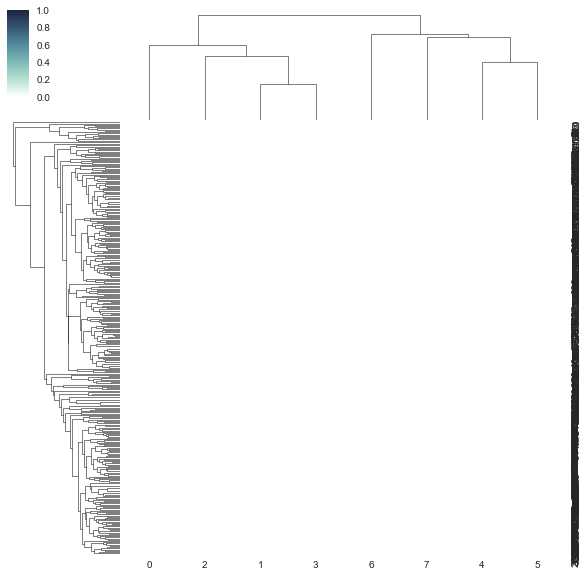

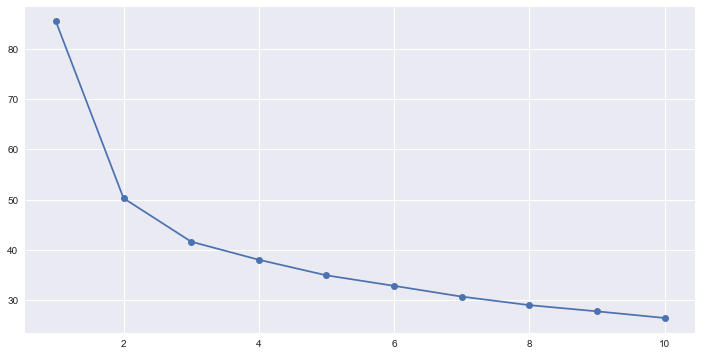

In [2166]:
plt.figure(figsize=(12,6))
plt.plot( clusters_dww.num_clusters, clusters_dww.cluster_errors, marker = "o" )
plt.show()

### silhouette analysis

For n_clusters = 2 The average silhouette_score is : 0.33716651939


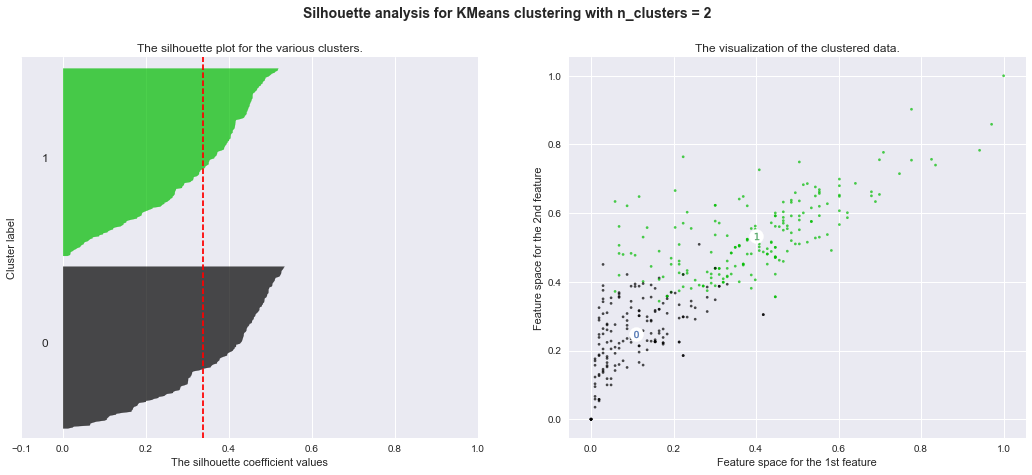

For n_clusters = 3 The average silhouette_score is : 0.237325165529


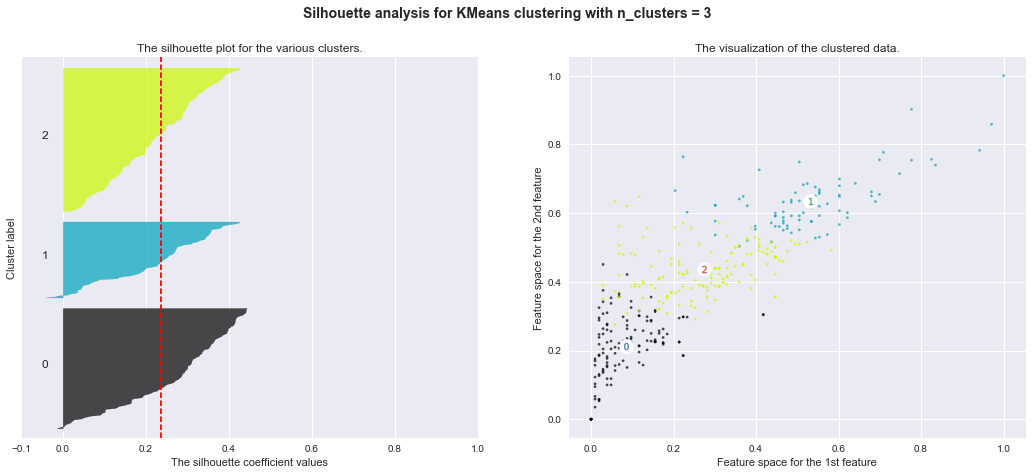

For n_clusters = 4 The average silhouette_score is : 0.174526205393


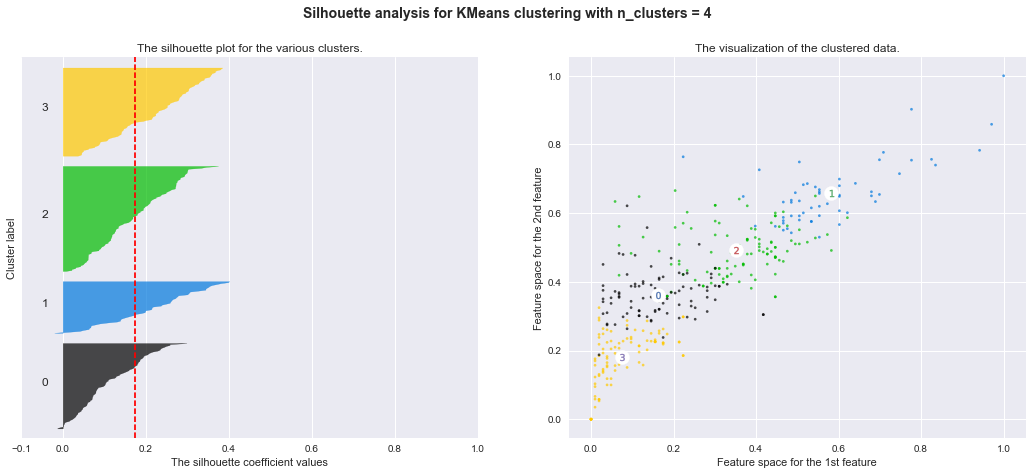

For n_clusters = 5 The average silhouette_score is : 0.166114663785


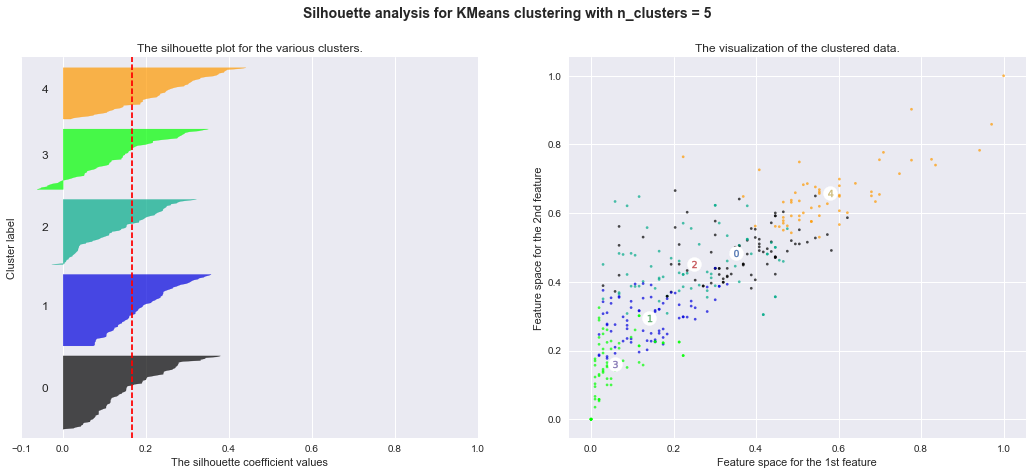

For n_clusters = 6 The average silhouette_score is : 0.173056514675


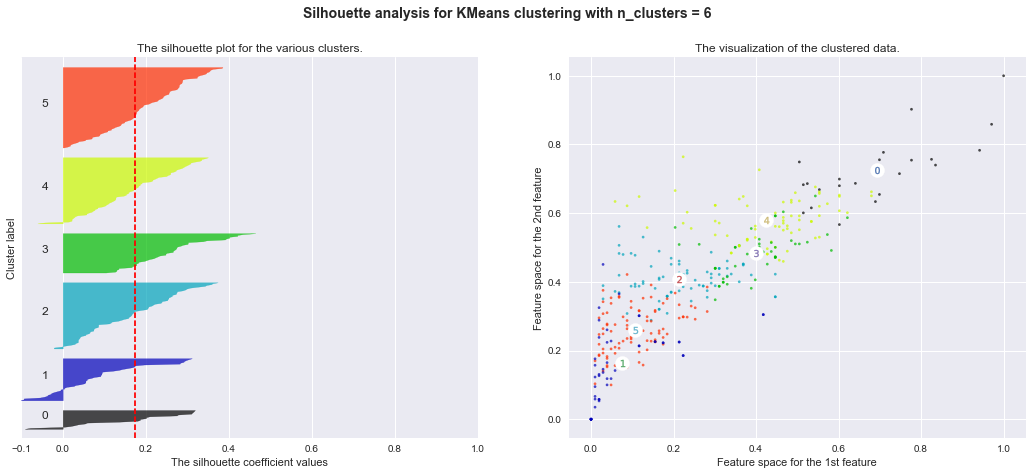

For n_clusters = 7 The average silhouette_score is : 0.169491367327


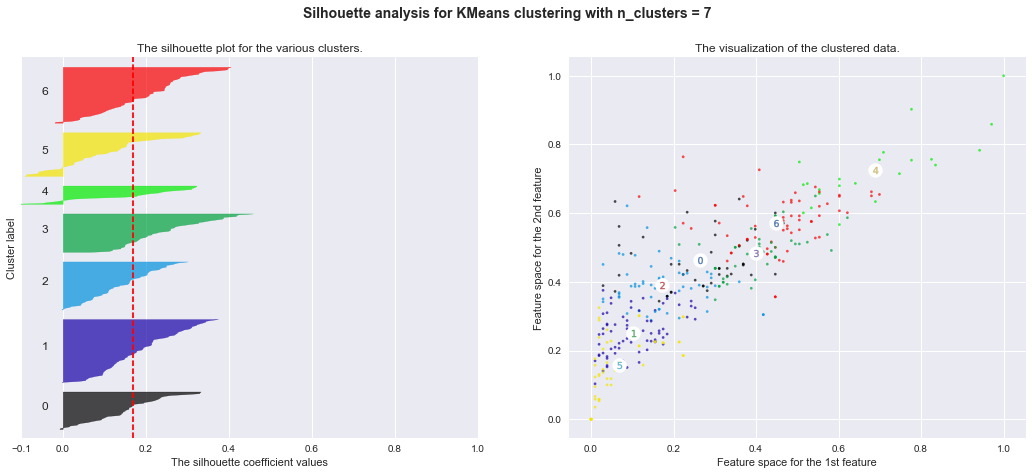

For n_clusters = 8 The average silhouette_score is : 0.164056833993


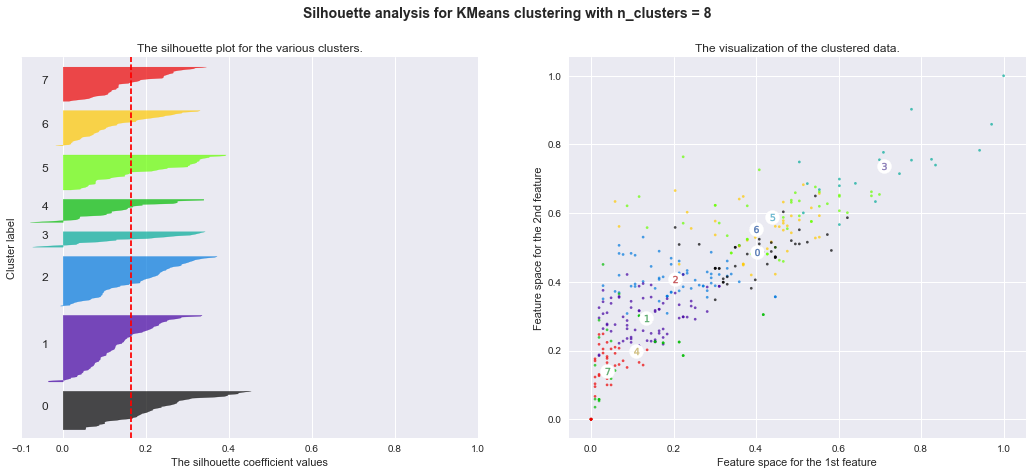

For n_clusters = 9 The average silhouette_score is : 0.160391758002


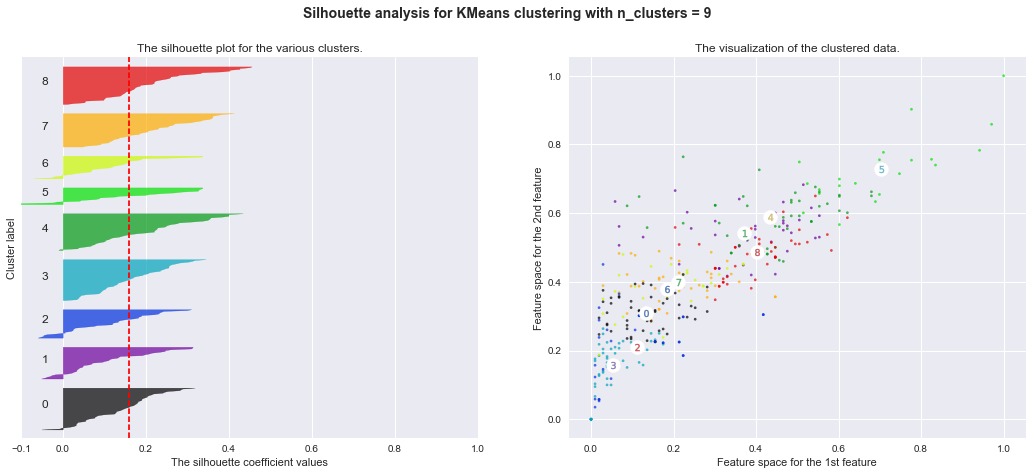

For n_clusters = 10 The average silhouette_score is : 0.167516787649


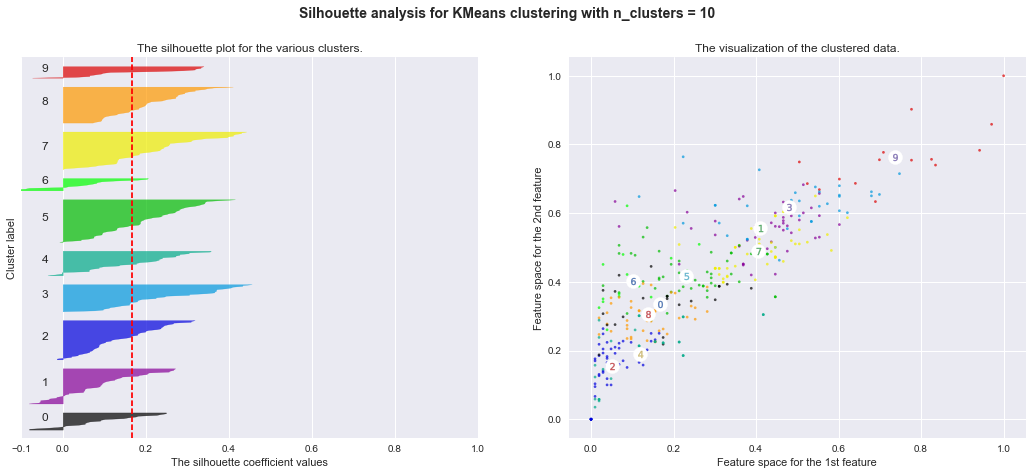

In [2167]:
cluster_range = range( 2, 11 )

for n_clusters in cluster_range:
  # Create a subplot with 1 row and 2 columns
  fig, (ax1, ax2) = plt.subplots(1, 2)
  fig.set_size_inches(18, 7)

  # The 1st subplot is the silhouette plot
  # The silhouette coefficient can range from -1, 1 but in this example all
  # lie within [-0.1, 1]
  ax1.set_xlim([-0.1, 1])
  # The (n_clusters+1)*10 is for inserting blank space between silhouette
  # plots of individual clusters, to demarcate them clearly.
  ax1.set_ylim([0, len(w_scaled) + (n_clusters + 1) * 10])

  # Initialize the clusterer with n_clusters value and a random generator
  # seed of 10 for reproducibility.
  clusterer = KMeans(n_clusters=n_clusters, max_iter=1000, random_state=10)
  cluster_labels = clusterer.fit_predict( w_scaled )

  # The silhouette_score gives the average value for all the samples.
  # This gives a perspective into the density and separation of the formed
  # clusters
  silhouette_avg = silhouette_score(w_scaled, cluster_labels)
  print("For n_clusters =", n_clusters,
        "The average silhouette_score is :", silhouette_avg)

  # Compute the silhouette scores for each sample
  sample_silhouette_values = silhouette_samples(w_scaled, cluster_labels)

  y_lower = 10
  for i in range(n_clusters):
      # Aggregate the silhouette scores for samples belonging to
      # cluster i, and sort them
      ith_cluster_silhouette_values = \
          sample_silhouette_values[cluster_labels == i]

      ith_cluster_silhouette_values.sort()

      size_cluster_i = ith_cluster_silhouette_values.shape[0]
      y_upper = y_lower + size_cluster_i

      color = cm.spectral(float(i) / n_clusters)
      ax1.fill_betweenx(np.arange(y_lower, y_upper),
                        0, ith_cluster_silhouette_values,
                        facecolor=color, edgecolor=color, alpha=0.7)

      # Label the silhouette plots with their cluster numbers at the middle
      ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

      # Compute the new y_lower for next plot
      y_lower = y_upper + 10  # 10 for the 0 samples

  ax1.set_title("The silhouette plot for the various clusters.")
  ax1.set_xlabel("The silhouette coefficient values")
  ax1.set_ylabel("Cluster label")

  # The vertical line for average silhoutte score of all the values
  ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

  ax1.set_yticks([])  # Clear the yaxis labels / ticks
  ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

  # 2nd Plot showing the actual clusters formed
  colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
  ax2.scatter(w_scaled[:, 0], w_scaled[:, 1], marker='.', s=30, lw=0, alpha=0.7,
              c=colors)

  # Labeling the clusters
  centers = clusterer.cluster_centers_
  # Draw white circles at cluster centers
  ax2.scatter(centers[:, 0], centers[:, 1],
              marker='o', c="white", alpha=1, s=200)

  for i, c in enumerate(centers):
      ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

  ax2.set_title("The visualization of the clustered data.")
  ax2.set_xlabel("Feature space for the 1st feature")
  ax2.set_ylabel("Feature space for the 2nd feature")

  plt.suptitle(("Silhouette analysis for KMeans clustering "
                "with n_clusters = %d" % n_clusters),
               fontsize=14, fontweight='bold')

  plt.show()

In [2168]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(w_scaled)

clusters_dww = pd.DataFrame(kmeans.cluster_centers_,
                       columns=['TPoints', 'TOIPoints', 'TOIGoals', 'TOIAssists', 'TPlus/Minus', 'TOIPlus/Minus', 'TOIShots', 'TOIShotsA'])

dww['cluster']=kmeans.labels_

clusters_dww

,TPoints,TOIPoints,TOIGoals,TOIAssists,TPlus/Minus,TOIPlus/Minus,TOIShots,TOIShotsA
0,0.358062,0.494069,0.532136,0.426037,0.409239,0.574844,0.514608,0.649575
1,0.077585,0.201220,0.187897,0.194896,0.380409,0.474963,0.554102,0.389745
2,0.206416,0.399958,0.341493,0.411116,0.507065,0.631815,0.537810,0.500745
3,0.578172,0.655815,0.603017,0.642162,0.656609,0.681717,0.502102,0.646170


In [2134]:
#clusters_dww.to_csv('/Users/stefanostselios/Brock University/Kevin Mongeon - StephanosShare/out/clusters/clusters_wingers.csv')
#clusters_dww.to_csv('/Users/kevinmongeon/Brock University/Steve Tselios - StephanosShare/out/clusters/clusters_wingers.csv')

### rank wingers

The next step is to rank players based on clusters:

- **Cluster 0** is for **1st** line (Top 3). 
- **Cluster 2** is for **2nd** second line (Top 6). 
- **Cluster 1** is for **3rd** third line (Top 9)
- **Cluster 3** is for **4th** fourth line (Bottom 3)

In [2169]:
dww['Rank'] = dww.apply(lambda x: 1 if (x['cluster'] == 3) else 2 if (x['cluster'] == 0) else 3 if (x['cluster'] == 2) else 4, axis=1)
dww = dww.sort_values(['Points'], ascending=[False])
#dww.head()

In [2170]:
dww['Rank'].value_counts()

4    114
3     92
2     92
1     58
Name: Rank, dtype: int64

In [2160]:
dww = dww.sort_values(['Rank', 'TPoints'], ascending=[True, False])
#dww.head(55)

In [2174]:
c4 = dww[dww['Rank'] == 2]
c4 = c4.sort_values(['TPoints'], ascending=[ False])
c4.tail()

,Season,TeamCode,PlayerNumber,PlayerName,Position,GP,Goals,Assists,Points,GoalsF,GoalsA,Plus/Minus,Shots,ShotsA,ShotRatio,Blocks,Hits,Faceoffs,Misses,Penalties,Giveaways,Takeaways,TOI,ATOI,TGP,TPoints,TGoals,TAssists,TGoalsF,TGoalsA,TPlus/Minus,TShots,TShotsA,TBlocks,THits,TFaceoffs,TMisses,TPenalties,TGiveaways,TTakeaways,TTOI,TOIPoints,TOIGoals,TOIAssists,TOIGoalsF,TOIGoalsA,TOIPlus/Minus,TOIShots,TOIShotsA,TOIMisses,TOIBlocks,TOIHits,TOIFaceoffs,TOIPenalties,TOIGiveaways,TOITakeaways,TATOI,cluster,Rank
85,2010,CAR,11.0,BOYCHUK,W,22,4,3,7,8.0,10.0,-2.0,44,140.0,0.314286,6,50,1,7,2,7,5,246.62,10.72,22.0,7.0,4.0,3.0,8.0,10.0,-2.0,44.0,140.0,6.0,50.0,1.0,7.0,2.0,7.0,5.0,246.62,0.028384,0.016219,0.012164,0.032439,0.040548,-0.008110,0.178412,0.567675,0.028384,0.024329,0.202741,0.004055,0.008110,0.318182,0.020274,11.210000,0,2
4,2010,STL,57.0,PERRON,W,10,5,2,7,8.0,2.0,6.0,29,66.0,0.439394,1,6,0,5,6,3,9,184.18,18.42,10.0,7.0,5.0,2.0,8.0,2.0,6.0,29.0,66.0,1.0,6.0,0.0,5.0,6.0,3.0,9.0,184.18,0.038006,0.027147,0.010859,0.043436,0.010859,0.032577,0.157455,0.358345,0.027147,0.005429,0.032577,0.000000,0.032577,0.300000,0.048865,18.418000,0,2
83,2010,FLA,37.0,THOMAS,W,22,4,3,7,7.0,6.0,1.0,33,93.0,0.354839,10,19,13,12,3,3,8,204.19,8.51,22.0,7.0,4.0,3.0,7.0,6.0,1.0,33.0,93.0,10.0,19.0,13.0,12.0,3.0,3.0,8.0,204.19,0.034282,0.019590,0.014692,0.034282,0.029384,0.004897,0.161614,0.455458,0.058769,0.048974,0.093051,0.063666,0.014692,0.136364,0.039179,9.281364,0,2
7,2010,MIN,48.0,LATENDRESSE,W,11,3,3,6,6.0,3.0,3.0,18,62.0,0.290323,2,18,0,8,4,4,2,139.79,12.71,11.0,6.0,3.0,3.0,6.0,3.0,3.0,18.0,62.0,2.0,18.0,0.0,8.0,4.0,4.0,2.0,139.79,0.042922,0.021461,0.021461,0.042922,0.021461,0.021461,0.128765,0.443522,0.057229,0.014307,0.128765,0.000000,0.028614,0.363636,0.014307,12.708182,0,2
27,2010,NJ,9.0,PARISE,W,13,3,3,6,9.0,10.0,-1.0,49,121.0,0.404959,6,13,4,9,3,4,6,238.12,18.32,13.0,6.0,3.0,3.0,9.0,10.0,-1.0,49.0,121.0,6.0,13.0,4.0,9.0,3.0,4.0,6.0,238.12,0.025197,0.012599,0.012599,0.037796,0.041996,-0.004200,0.205779,0.508147,0.037796,0.025197,0.054594,0.016798,0.012599,0.307692,0.025197,18.316923,0,2


## clusters for defensemen

- create a data frame for defensemen (LD, RD) and exclude faceoff per time on ice (MFaceoffs) variable. Follow the same process as above (forwards).

In [2266]:
ddf = dws[(dws['Position'] != 'C') & (dws['Position'] != 'W')]
ddf = ddf.sort_values(['GP', 'TOI'], ascending=[True, True])
ddf.head()

,Season,TeamCode,PlayerNumber,PlayerName,Position,GP,Goals,Assists,Points,GoalsF,GoalsA,Plus/Minus,Shots,ShotsA,Blocks,Hits,Faceoffs,Misses,Penalties,Giveaways,Takeaways,TOI,ATOI
1016,2010,PHI,24.0,BOYNTON,D,10,0,0,0,1.0,4.0,-3.0,1,58.0,13,11,0,4,2,1,0,102.48,10.25
934,2010,COL,43.0,GAUNCE,D,10,1,0,1,2.0,5.0,-3.0,4,80.0,7,10,0,3,5,5,1,140.05,12.73
548,2010,LA,6.0,MUZZIN,D,11,0,1,1,2.0,4.0,-2.0,8,67.0,2,22,0,2,0,7,2,150.85,13.71
1023,2010,TOR,29.0,LASHOFF,D,11,0,1,1,5.0,2.0,3.0,8,84.0,14,10,0,7,3,4,6,152.16,13.83
968,2010,NYI,71.0,KATIC,D,11,0,1,1,3.0,11.0,-8.0,8,87.0,21,8,0,2,1,4,13,180.70,16.43


In [2267]:
d= ddf.copy()
d['Count'] = d.apply(lambda x: 1 if (x['PlayerName'] == x['PlayerName']) else 0, axis=1)
d['Player'] = d.groupby('PlayerName')['Count'].transform('sum')
d = d[d['Player'] > 1]

In [2268]:
ddf.shape

(274, 23)

In [2269]:
# exclude players that have the same name but are different individuals
d = d[(d['PlayerName'] !='WEBER') & (d['PlayerName'] !='SCHULTZ') & (d['PlayerName'] !='WILSON') & (d['PlayerName'] !='GREENE')]

# total games played for the season
d['TGP'] = d.apply(lambda x: 0 if ((x['PlayerName'] == 'WHITE') & (x['TeamCode'] == 'NJ')) else 0 if ((x['PlayerName'] == 'JOHNSON') & (x['TeamCode'] == 'LA')) else 0 if ((x['PlayerName'] == 'STUART') & (x['TeamCode'] == 'DET')) else x['GP'], axis=1)
d['TGP'] = d.groupby('PlayerName')['TGP'].transform('sum')
d['TGP'] = d.apply(lambda x: x['GP'] if ((x['PlayerName'] == 'WHITE') & (x['TeamCode'] == 'NJ')) else x['GP'] if ((x['PlayerName'] == 'JOHNSON') & (x['TeamCode'] == 'LA')) else x['GP'] if ((x['PlayerName'] == 'STUART') & (x['TeamCode'] == 'DET')) else x['TGP'], axis=1)

# total points for the season
d['TPoints'] = d.apply(lambda x: 0 if ((x['PlayerName'] == 'WHITE') & (x['TeamCode'] == 'NJ')) else 0 if ((x['PlayerName'] == 'JOHNSON') & (x['TeamCode'] == 'LA')) else 0 if ((x['PlayerName'] == 'STUART') & (x['TeamCode'] == 'DET')) else x['Points'], axis=1)
d['TPoints'] = d.groupby('PlayerName')['TPoints'].transform('sum')
d['TPoints'] = d.apply(lambda x: x['Points'] if ((x['PlayerName'] == 'WHITE') & (x['TeamCode'] == 'NJ')) else x['Points'] if ((x['PlayerName'] == 'JOHNSON') & (x['TeamCode'] == 'LA')) else x['Points'] if ((x['PlayerName'] == 'STUART') & (x['TeamCode'] == 'DET')) else x['TPoints'], axis=1)

# total goals for the season
d['TGoals'] = d.apply(lambda x: 0 if ((x['PlayerName'] == 'WHITE') & (x['TeamCode'] == 'NJ')) else 0 if ((x['PlayerName'] == 'JOHNSON') & (x['TeamCode'] == 'LA')) else 0 if ((x['PlayerName'] == 'STUART') & (x['TeamCode'] == 'DET')) else x['Goals'], axis=1)
d['TGoals'] = d.groupby('PlayerName')['TGoals'].transform('sum')
d['TGoals'] = d.apply(lambda x: x['Goals'] if ((x['PlayerName'] == 'WHITE') & (x['TeamCode'] == 'NJ')) else x['Goals'] if ((x['PlayerName'] == 'JOHNSON') & (x['TeamCode'] == 'LA')) else x['Goals'] if ((x['PlayerName'] == 'STUART') & (x['TeamCode'] == 'DET')) else x['TGoals'], axis=1)

# total assists for the season
d['TAssists'] = d.apply(lambda x: 0 if ((x['PlayerName'] == 'WHITE') & (x['TeamCode'] == 'NJ')) else 0 if ((x['PlayerName'] == 'JOHNSON') & (x['TeamCode'] == 'LA')) else 0 if ((x['PlayerName'] == 'STUART') & (x['TeamCode'] == 'DET')) else x['Assists'], axis=1)
d['TAssists'] = d.groupby('PlayerName')['TAssists'].transform('sum')
d['TAssists'] = d.apply(lambda x: x['Assists'] if ((x['PlayerName'] == 'WHITE') & (x['TeamCode'] == 'NJ')) else x['Assists'] if ((x['PlayerName'] == 'JOHNSON') & (x['TeamCode'] == 'LA')) else x['Assists'] if ((x['PlayerName'] == 'STUART') & (x['TeamCode'] == 'DET')) else x['TAssists'], axis=1)

# total goals for on-ice for the season
d['TGoalsF'] = d.apply(lambda x: 0 if ((x['PlayerName'] == 'WHITE') & (x['TeamCode'] == 'NJ')) else 0 if ((x['PlayerName'] == 'JOHNSON') & (x['TeamCode'] == 'LA')) else 0 if ((x['PlayerName'] == 'STUART') & (x['TeamCode'] == 'DET')) else x['GoalsF'], axis=1)
d['TGoalsF'] = d.groupby('PlayerName')['TGoalsF'].transform('sum')
d['TGoalsF'] = d.apply(lambda x: x['GoalsF'] if ((x['PlayerName'] == 'WHITE') & (x['TeamCode'] == 'NJ')) else x['GoalsF'] if ((x['PlayerName'] == 'JOHNSON') & (x['TeamCode'] == 'LA')) else x['GoalsF'] if ((x['PlayerName'] == 'STUART') & (x['TeamCode'] == 'DET')) else x['TGoalsF'], axis=1)

# total goals against on-ice for the season
d['TGoalsA'] = d.apply(lambda x: 0 if ((x['PlayerName'] == 'WHITE') & (x['TeamCode'] == 'NJ')) else 0 if ((x['PlayerName'] == 'JOHNSON') & (x['TeamCode'] == 'LA')) else 0 if ((x['PlayerName'] == 'STUART') & (x['TeamCode'] == 'DET')) else x['GoalsA'], axis=1)
d['TGoalsA'] = d.groupby('PlayerName')['TGoalsA'].transform('sum')
d['TGoalsA'] = d.apply(lambda x: x['GoalsA'] if ((x['PlayerName'] == 'WHITE') & (x['TeamCode'] == 'NJ')) else x['GoalsA'] if ((x['PlayerName'] == 'JOHNSON') & (x['TeamCode'] == 'LA')) else x['GoalsA'] if ((x['PlayerName'] == 'STUART') & (x['TeamCode'] == 'DET')) else x['TGoalsA'], axis=1)

# total shots against on-ice for the season
d['TPlus/Minus'] = d.apply(lambda x: 0 if ((x['PlayerName'] == 'WHITE') & (x['TeamCode'] == 'NJ')) else 0 if ((x['PlayerName'] == 'JOHNSON') & (x['TeamCode'] == 'LA')) else 0 if ((x['PlayerName'] == 'STUART') & (x['TeamCode'] == 'DET')) else x['Plus/Minus'], axis=1)
d['TPlus/Minus'] = d.groupby('PlayerName')['TPlus/Minus'].transform('sum')
d['TPlus/Minus'] = d.apply(lambda x: x['Plus/Minus'] if ((x['PlayerName'] == 'WHITE') & (x['TeamCode'] == 'NJ')) else x['Plus/Minus'] if ((x['PlayerName'] == 'JOHNSON') & (x['TeamCode'] == 'LA')) else x['Plus/Minus'] if ((x['PlayerName'] == 'STUART') & (x['TeamCode'] == 'DET')) else x['TPlus/Minus'], axis=1)

# total shots against on-ice for the season
d['TShots'] = d.apply(lambda x: 0 if ((x['PlayerName'] == 'WHITE') & (x['TeamCode'] == 'NJ')) else 0 if ((x['PlayerName'] == 'JOHNSON') & (x['TeamCode'] == 'LA')) else 0 if ((x['PlayerName'] == 'STUART') & (x['TeamCode'] == 'DET')) else x['Shots'], axis=1)
d['TShots'] = d.groupby('PlayerName')['TShots'].transform('sum')
d['TShots'] = d.apply(lambda x: x['Shots'] if ((x['PlayerName'] == 'WHITE') & (x['TeamCode'] == 'NJ')) else x['Shots'] if ((x['PlayerName'] == 'JOHNSON') & (x['TeamCode'] == 'LA')) else x['Shots'] if ((x['PlayerName'] == 'STUART') & (x['TeamCode'] == 'DET')) else x['TShots'], axis=1)

# total shots against on-ice for the season
d['TShotsA'] = d.apply(lambda x: 0 if ((x['PlayerName'] == 'WHITE') & (x['TeamCode'] == 'NJ')) else 0 if ((x['PlayerName'] == 'JOHNSON') & (x['TeamCode'] == 'LA')) else 0 if ((x['PlayerName'] == 'STUART') & (x['TeamCode'] == 'DET')) else x['ShotsA'], axis=1)
d['TShotsA'] = d.groupby('PlayerName')['TShotsA'].transform('sum')
d['TShotsA'] = d.apply(lambda x: x['ShotsA'] if ((x['PlayerName'] == 'WHITE') & (x['TeamCode'] == 'NJ')) else x['ShotsA'] if ((x['PlayerName'] == 'JOHNSON') & (x['TeamCode'] == 'LA')) else x['ShotsA'] if ((x['PlayerName'] == 'STUART') & (x['TeamCode'] == 'DET')) else x['TShotsA'], axis=1)

# total blocks for the season
d['TBlocks'] = d.apply(lambda x: 0 if ((x['PlayerName'] == 'WHITE') & (x['TeamCode'] == 'NJ')) else 0 if ((x['PlayerName'] == 'JOHNSON') & (x['TeamCode'] == 'LA')) else 0 if ((x['PlayerName'] == 'STUART') & (x['TeamCode'] == 'DET')) else x['Blocks'], axis=1)
d['TBlocks'] = d.groupby('PlayerName')['TBlocks'].transform('sum')
d['TBlocks'] = d.apply(lambda x: x['Blocks'] if ((x['PlayerName'] == 'WHITE') & (x['TeamCode'] == 'NJ')) else x['Blocks'] if ((x['PlayerName'] == 'JOHNSON') & (x['TeamCode'] == 'LA')) else x['Blocks'] if ((x['PlayerName'] == 'STUART') & (x['TeamCode'] == 'DET')) else x['TBlocks'], axis=1)

# total hits for the season
d['THits'] = d.apply(lambda x: 0 if ((x['PlayerName'] == 'WHITE') & (x['TeamCode'] == 'NJ')) else 0 if ((x['PlayerName'] == 'JOHNSON') & (x['TeamCode'] == 'LA')) else 0 if ((x['PlayerName'] == 'STUART') & (x['TeamCode'] == 'DET')) else x['Hits'], axis=1)
d['THits'] = d.groupby('PlayerName')['THits'].transform('sum')
d['THits'] = d.apply(lambda x: x['Hits'] if ((x['PlayerName'] == 'WHITE') & (x['TeamCode'] == 'NJ')) else x['Hits'] if ((x['PlayerName'] == 'JOHNSON') & (x['TeamCode'] == 'LA')) else x['Hits'] if ((x['PlayerName'] == 'STUART') & (x['TeamCode'] == 'DET')) else x['THits'], axis=1)

# total misses for the season
d['TMisses'] = d.apply(lambda x: 0 if ((x['PlayerName'] == 'WHITE') & (x['TeamCode'] == 'NJ')) else 0 if ((x['PlayerName'] == 'JOHNSON') & (x['TeamCode'] == 'LA')) else 0 if ((x['PlayerName'] == 'STUART') & (x['TeamCode'] == 'DET')) else x['Misses'], axis=1)
d['TMisses'] = d.groupby('PlayerName')['TMisses'].transform('sum')
d['TMisses'] = d.apply(lambda x: x['Misses'] if ((x['PlayerName'] == 'WHITE') & (x['TeamCode'] == 'NJ')) else x['Misses'] if ((x['PlayerName'] == 'JOHNSON') & (x['TeamCode'] == 'LA')) else x['Misses'] if ((x['PlayerName'] == 'STUART') & (x['TeamCode'] == 'DET')) else x['TMisses'], axis=1)

# total penalties for the season
d['TPenalties'] = d.apply(lambda x: 0 if ((x['PlayerName'] == 'WHITE') & (x['TeamCode'] == 'NJ')) else 0 if ((x['PlayerName'] == 'JOHNSON') & (x['TeamCode'] == 'LA')) else 0 if ((x['PlayerName'] == 'STUART') & (x['TeamCode'] == 'DET')) else x['Penalties'], axis=1)
d['TPenalties'] = d.groupby('PlayerName')['TPenalties'].transform('sum')
d['TPenalties'] = d.apply(lambda x: x['Penalties'] if ((x['PlayerName'] == 'WHITE') & (x['TeamCode'] == 'NJ')) else x['Penalties'] if ((x['PlayerName'] == 'JOHNSON') & (x['TeamCode'] == 'LA')) else x['Penalties'] if ((x['PlayerName'] == 'STUART') & (x['TeamCode'] == 'DET')) else x['TPenalties'], axis=1)

# total giveaways for the season
d['TGiveaways'] = d.apply(lambda x: 0 if ((x['PlayerName'] == 'WHITE') & (x['TeamCode'] == 'NJ')) else 0 if ((x['PlayerName'] == 'JOHNSON') & (x['TeamCode'] == 'LA')) else 0 if ((x['PlayerName'] == 'STUART') & (x['TeamCode'] == 'DET')) else x['Giveaways'], axis=1)
d['TGiveaways'] = d.groupby('PlayerName')['TGiveaways'].transform('sum')
d['TGiveaways'] = d.apply(lambda x: x['Giveaways'] if ((x['PlayerName'] == 'WHITE') & (x['TeamCode'] == 'NJ')) else x['Giveaways'] if ((x['PlayerName'] == 'JOHNSON') & (x['TeamCode'] == 'LA')) else x['Giveaways'] if ((x['PlayerName'] == 'STUART') & (x['TeamCode'] == 'DET')) else x['TGiveaways'], axis=1)

# total takeaways for the season
d['TTakeaways'] = d.apply(lambda x: 0 if ((x['PlayerName'] == 'WHITE') & (x['TeamCode'] == 'NJ')) else 0 if ((x['PlayerName'] == 'JOHNSON') & (x['TeamCode'] == 'LA')) else 0 if ((x['PlayerName'] == 'STUART') & (x['TeamCode'] == 'DET')) else x['Takeaways'], axis=1)
d['TTakeaways'] = d.groupby('PlayerName')['TTakeaways'].transform('sum')
d['TTakeaways'] = d.apply(lambda x: x['Takeaways'] if ((x['PlayerName'] == 'WHITE') & (x['TeamCode'] == 'NJ')) else x['Takeaways'] if ((x['PlayerName'] == 'JOHNSON') & (x['TeamCode'] == 'LA')) else x['Takeaways'] if ((x['PlayerName'] == 'STUART') & (x['TeamCode'] == 'DET')) else x['TTakeaways'], axis=1)

# time on ice for the season
d['TTOI'] = d.apply(lambda x: 0 if ((x['PlayerName'] == 'WHITE') & (x['TeamCode'] == 'NJ')) else 0 if ((x['PlayerName'] == 'JOHNSON') & (x['TeamCode'] == 'LA')) else 0 if ((x['PlayerName'] == 'STUART') & (x['TeamCode'] == 'DET')) else x['TOI'], axis=1)
d['TTOI'] = d.groupby('PlayerName')['TTOI'].transform('sum')
d['TTOI'] = d.apply(lambda x: x['Points'] if ((x['PlayerName'] == 'WHITE') & (x['TeamCode'] == 'NJ')) else x['TOI'] if ((x['PlayerName'] == 'JOHNSON') & (x['TeamCode'] == 'LA')) else x['TOI'] if ((x['PlayerName'] == 'STUART') & (x['TeamCode'] == 'DET')) else x['TTOI'], axis=1)

In [2270]:
dwd = pd.merge(ddf, d, on=['Season', 'TeamCode', 'PlayerNumber', 'PlayerName', 'Position', 'GP', 'Goals', 'Assists', 'Points', 'GoalsF', 'GoalsA', 'Plus/Minus', 'Shots', 'ShotsA', 'Blocks', 'Hits', 'Misses', 'Penalties', 'Giveaways', 'Takeaways', 'TOI', 'ATOI'], how='left')
dwd = dwd[['Season', 'TeamCode', 'PlayerNumber', 'PlayerName', 'Position', 'GP', 'Goals', 'Assists', 'Points', 'GoalsF', 'GoalsA', 'Plus/Minus', 'Shots', 'ShotsA', 'Blocks', 'Hits', 'Misses', 'Penalties', 'Giveaways', 'Takeaways', 'TOI', 'ATOI', 'TGP', 'TPoints', 'TGoals', 'TAssists', 'TGoalsF', 'TGoalsA', 'TPlus/Minus', 'TShots', 'TShotsA', 'TBlocks', 'THits', 'TMisses', 'TPenalties', 'TGiveaways', 'TTakeaways', 'TTOI']]

In [2271]:
dwd['TGP'] = dwd.apply(lambda x: x['GP'] if pd.isnull(x['TGP']) else x['TGP'], axis=1)

dwd['TPoints'] = dwd.apply(lambda x: x['Points'] if pd.isnull(x['TPoints']) else x['TPoints'], axis=1)
dwd['TGoals'] = dwd.apply(lambda x: x['Goals'] if pd.isnull(x['TGoals']) else x['TGoals'], axis=1)
dwd['TAssists'] = dwd.apply(lambda x: x['Assists'] if pd.isnull(x['TAssists']) else x['TAssists'], axis=1)

dwd['TGoalsF'] = dwd.apply(lambda x: x['GoalsF'] if pd.isnull(x['TGoalsF']) else x['TGoalsF'], axis=1)
dwd['TGoalsA'] = dwd.apply(lambda x: x['GoalsA'] if pd.isnull(x['TGoalsA']) else x['TGoalsA'], axis=1)
dwd['TPlus/Minus'] = dwd.apply(lambda x: x['Plus/Minus'] if pd.isnull(x['TPlus/Minus']) else x['TPlus/Minus'], axis=1)

dwd['TShots'] = dwd.apply(lambda x: x['Shots'] if pd.isnull(x['TShots']) else x['TShots'], axis=1)
dwd['TShotsA'] = dwd.apply(lambda x: x['ShotsA'] if pd.isnull(x['TShotsA']) else x['TShotsA'], axis=1)
dwd['TMisses'] = dwd.apply(lambda x: x['Misses'] if pd.isnull(x['TMisses']) else x['TMisses'], axis=1)

dwd['TBlocks'] = dwd.apply(lambda x: x['Blocks'] if pd.isnull(x['TBlocks']) else x['TBlocks'], axis=1)
dwd['THits'] = dwd.apply(lambda x: x['Hits'] if pd.isnull(x['THits']) else x['THits'], axis=1)
dwd['TPenalties'] = dwd.apply(lambda x: x['Penalties'] if pd.isnull(x['TPenalties']) else x['TPenalties'], axis=1)

dwd['TGiveaways'] = dwd.apply(lambda x: x['Giveaways'] if pd.isnull(x['TGiveaways']) else x['TGiveaways'], axis=1)
dwd['TTakeaways'] = dwd.apply(lambda x: x['Takeaways'] if pd.isnull(x['TTakeaways']) else x['TTakeaways'], axis=1)

dwd['TTOI'] = dwd.apply(lambda x: x['TOI'] if pd.isnull(x['TTOI']) else x['TTOI'], axis=1)


In [2272]:
dwd['TOIPoints'] = dwd['TPoints']/dwd['TTOI']
dwd['TOIGoals'] = dwd['TGoals']/dwd['TTOI']
dwd['TOIAssists'] = dwd['TAssists']/dwd['TTOI']

dwd['TOIGoalsF'] = dwd['TGoalsF']/dwd['TTOI']
dwd['TOIGoalsA'] = dwd['TGoalsA']/dwd['TTOI']
dwd['TOIPlus/Minus'] = dwd['TPlus/Minus']/dwd['TTOI']

dwd['TOIShots'] = dwd['TShots']/dwd['TTOI']
dwd['TOIShotsA'] = dwd['TShotsA']/dwd['TTOI']
dwd['TOIMisses'] = dwd['TMisses']/dwd['TTOI']

dwd['TOIBlocks'] = dwd['TBlocks']/dwd['TTOI']
dwd['TOIHits'] = dwd['THits']/dwd['TTOI']
dwd['TOIPenalties'] = dwd['TPenalties']/dwd['TTOI']

dwd['TOIGiveaways'] = dwd['TGiveaways']/dwd['TGP']
dwd['TOITakeaways'] = dwd['TTakeaways']/dwd['TTOI']

dwd['TATOI'] = dwd['TTOI']/dwd['TGP']

In [2534]:
dwd.to_csv('/Users/stefanostselios/Brock University/Kevin Mongeon - StephanosShare/out/clusters/total_stats_defensemen.csv', index='False', sep=',')
#dwd.to_csv('/Users/kevinmongeon/Brock University/Steve Tselios - StephanosShare/out/clusters/total_stats_defensemen.csv', index='False', sep=',')

In [2273]:
dwd.head()

,Season,TeamCode,PlayerNumber,PlayerName,Position,GP,Goals,Assists,Points,GoalsF,GoalsA,Plus/Minus,Shots,ShotsA,Blocks,Hits,Misses,Penalties,Giveaways,Takeaways,TOI,ATOI,TGP,TPoints,TGoals,TAssists,TGoalsF,TGoalsA,TPlus/Minus,TShots,TShotsA,TBlocks,THits,TMisses,TPenalties,TGiveaways,TTakeaways,TTOI,TOIPoints,TOIGoals,TOIAssists,TOIGoalsF,TOIGoalsA,TOIPlus/Minus,TOIShots,TOIShotsA,TOIMisses,TOIBlocks,TOIHits,TOIPenalties,TOIGiveaways,TOITakeaways,TATOI
0,2010,PHI,24.0,BOYNTON,D,10,0,0,0,1.0,4.0,-3.0,1,58.0,13,11,4,2,1,0,102.48,10.25,51.0,8.0,1.0,7.0,32.0,33.0,-1.0,43.0,366.0,87.0,61.0,16.0,16.0,25.0,15.0,746.99,0.010710,0.001339,0.009371,0.042839,0.044177,-0.001339,0.057564,0.489966,0.021419,0.116467,0.081661,0.021419,0.490196,0.020081,14.646863
1,2010,COL,43.0,GAUNCE,D,10,1,0,1,2.0,5.0,-3.0,4,80.0,7,10,3,5,5,1,140.05,12.73,10.0,1.0,1.0,0.0,2.0,5.0,-3.0,4.0,80.0,7.0,10.0,3.0,5.0,5.0,1.0,140.05,0.007140,0.007140,0.000000,0.014281,0.035702,-0.021421,0.028561,0.571225,0.021421,0.049982,0.071403,0.035702,0.500000,0.007140,14.005000
2,2010,LA,6.0,MUZZIN,D,11,0,1,1,2.0,4.0,-2.0,8,67.0,2,22,2,0,7,2,150.85,13.71,11.0,1.0,0.0,1.0,2.0,4.0,-2.0,8.0,67.0,2.0,22.0,2.0,0.0,7.0,2.0,150.85,0.006629,0.000000,0.006629,0.013258,0.026516,-0.013258,0.053033,0.444150,0.013258,0.013258,0.145840,0.000000,0.636364,0.013258,13.713636
3,2010,TOR,29.0,LASHOFF,D,11,0,1,1,5.0,2.0,3.0,8,84.0,14,10,7,3,4,6,152.16,13.83,11.0,1.0,0.0,1.0,5.0,2.0,3.0,8.0,84.0,14.0,10.0,7.0,3.0,4.0,6.0,152.16,0.006572,0.000000,0.006572,0.032860,0.013144,0.019716,0.052576,0.552050,0.046004,0.092008,0.065720,0.019716,0.363636,0.039432,13.832727
4,2010,NYI,71.0,KATIC,D,11,0,1,1,3.0,11.0,-8.0,8,87.0,21,8,2,1,4,13,180.70,16.43,11.0,1.0,0.0,1.0,3.0,11.0,-8.0,8.0,87.0,21.0,8.0,2.0,1.0,4.0,13.0,180.70,0.005534,0.000000,0.005534,0.016602,0.060874,-0.044272,0.044272,0.481461,0.011068,0.116215,0.044272,0.005534,0.363636,0.071942,16.427273


In [2516]:
scaler = MinMaxScaler()
#scaler = StandardScaler()
d = dwd[['TPoints', 'TOIPoints', 'TAssists', 'TGoals', 'TPlus/Minus']]
d_scaled = scaler.fit_transform( d )

### dendrogram

In [2517]:
cmap = sn.cubehelix_palette(as_cmap=True, rot=-.3, light=1)

In [2518]:
sn.clustermap(d_scaled, cmap=cmap, linewidths=.5)

/anaconda/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


### elbow analysis

In [2519]:
cluster_range = range( 1, 11 )
cluster_errors = []

for num_clusters in cluster_range:
  clusters = KMeans( num_clusters )
  clusters.fit( d_scaled )
  cluster_errors.append( clusters.inertia_ )

In [2520]:
clusters_dwd = pd.DataFrame( { "num_clusters":cluster_range, "cluster_errors": cluster_errors } )
clusters_dwd[0:10]

,cluster_errors,num_clusters
0,41.047168,1
1,18.608462,2
2,13.520356,3
3,11.883904,4
4,10.419699,5
5,9.212289,6
6,8.194919,7
7,7.374803,8
8,6.585940,9
9,6.116049,10


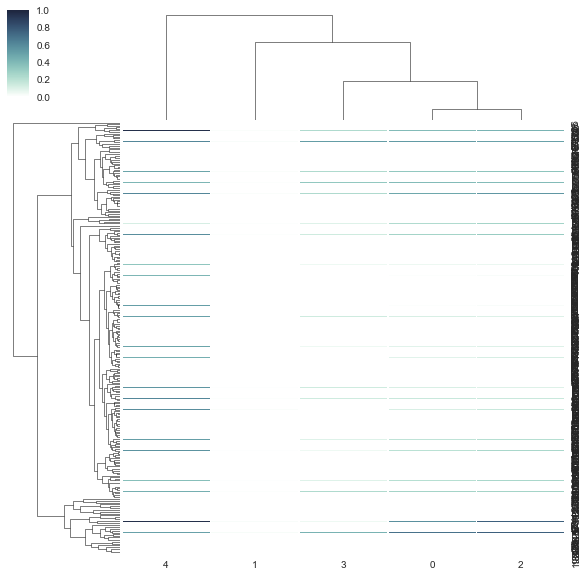

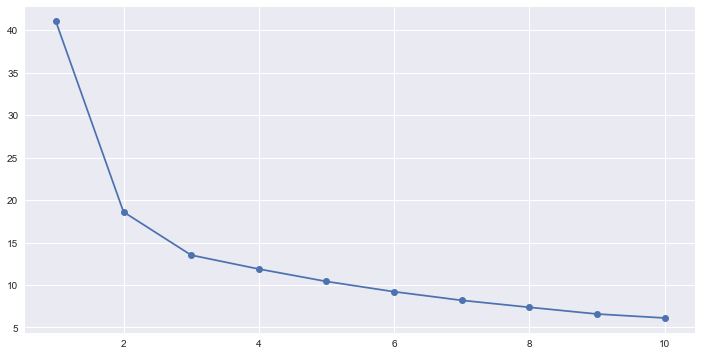

In [2521]:
plt.figure(figsize=(12,6))
plt.plot( clusters_dwd.num_clusters, clusters_dwd.cluster_errors, marker = "o" )
plt.show()

### silhouette analysis

For n_clusters = 2 The average silhouette_score is : 0.513189948977


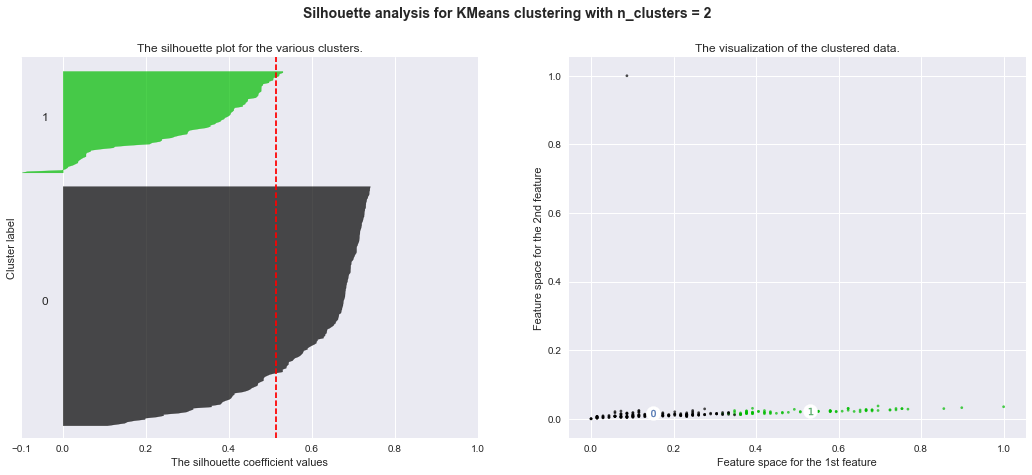

For n_clusters = 3 The average silhouette_score is : 0.39027829126


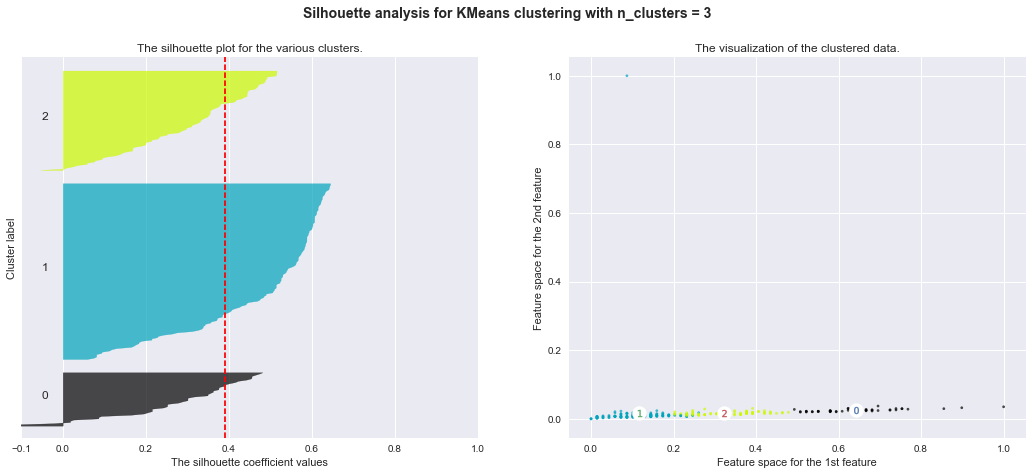

For n_clusters = 4 The average silhouette_score is : 0.281811219396


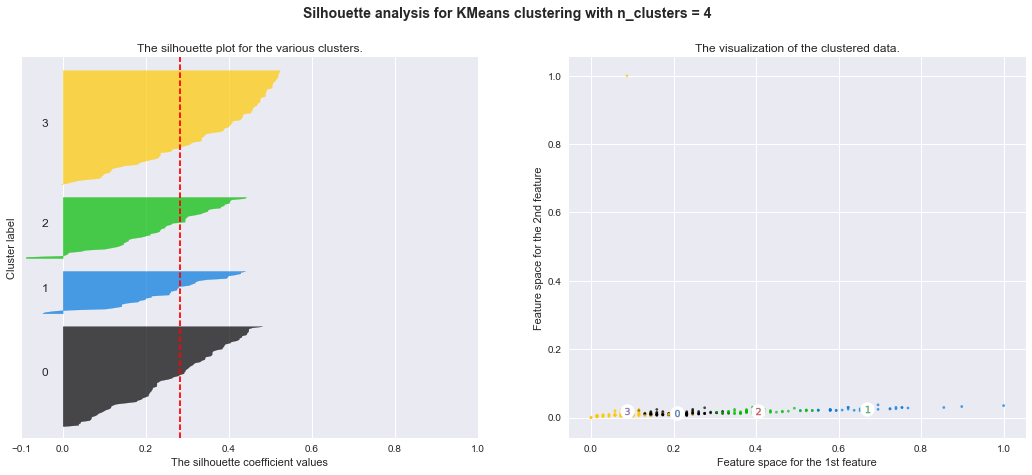

For n_clusters = 5 The average silhouette_score is : 0.296605569475


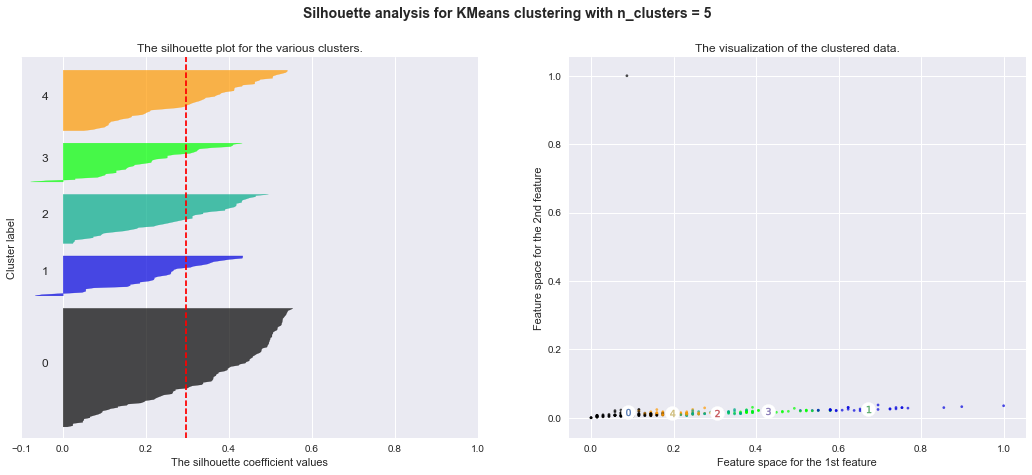

For n_clusters = 6 The average silhouette_score is : 0.311379119722


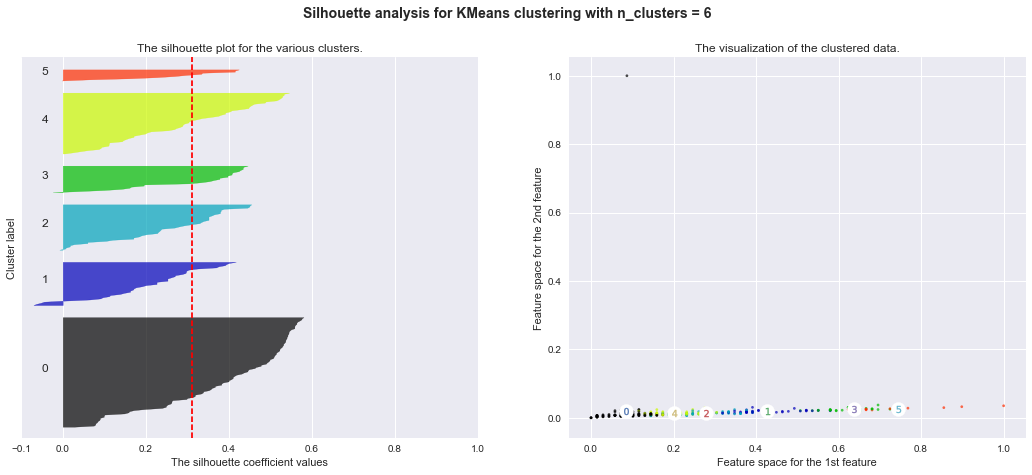

For n_clusters = 7 The average silhouette_score is : 0.318576974766


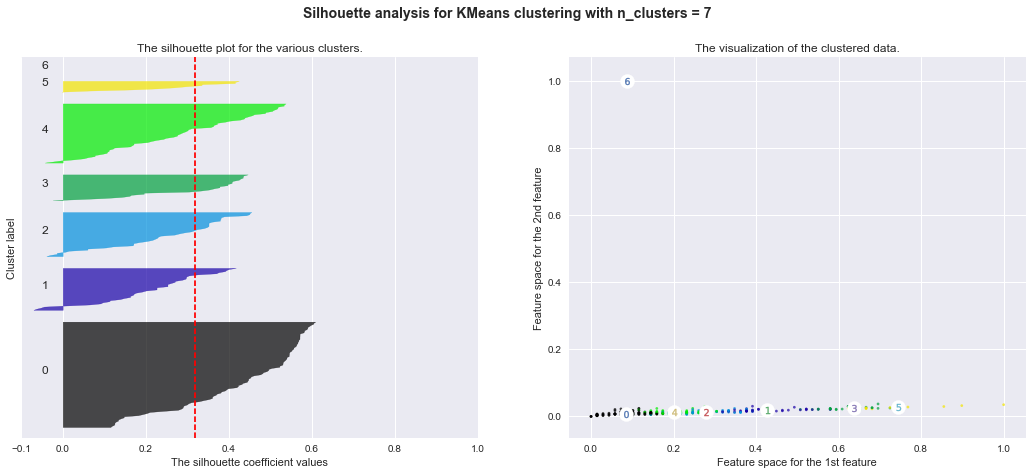

For n_clusters = 8 The average silhouette_score is : 0.312795224986


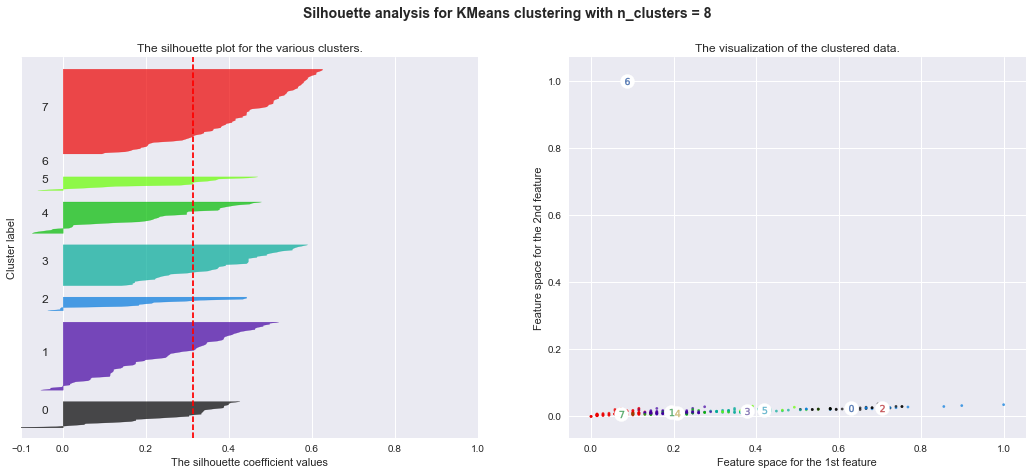

For n_clusters = 9 The average silhouette_score is : 0.3169875654


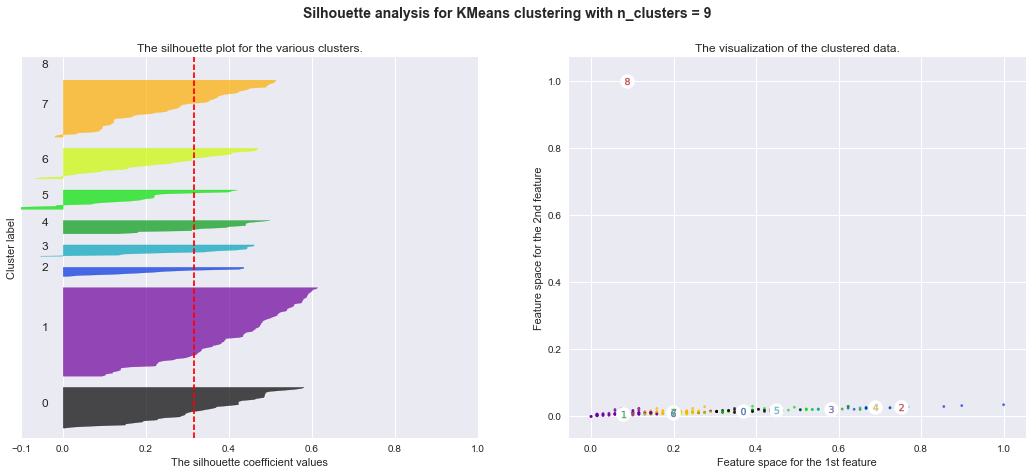

For n_clusters = 10 The average silhouette_score is : 0.27383268584


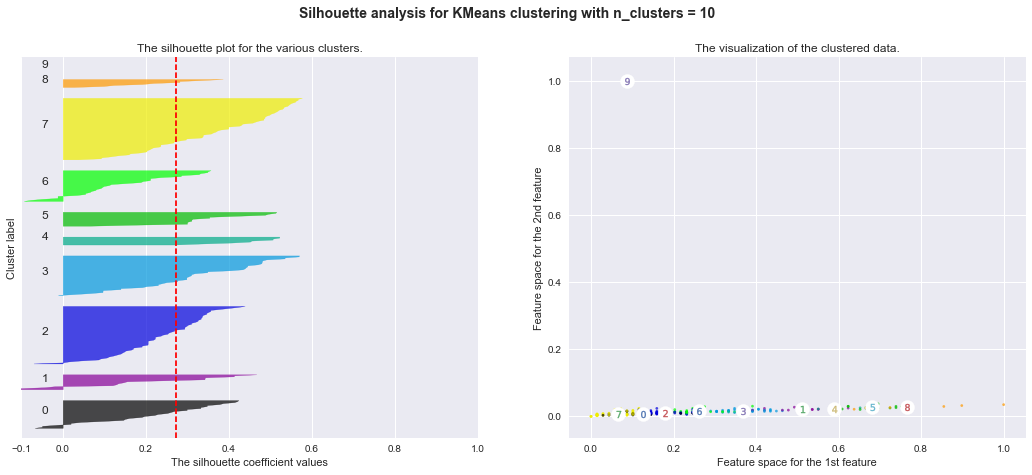

In [2522]:
cluster_range = range( 2, 11 )

for n_clusters in cluster_range:
  # Create a subplot with 1 row and 2 columns
  fig, (ax1, ax2) = plt.subplots(1, 2)
  fig.set_size_inches(18, 7)

  # The 1st subplot is the silhouette plot
  # The silhouette coefficient can range from -1, 1 but in this example all
  # lie within [-0.1, 1]
  ax1.set_xlim([-0.1, 1])
  # The (n_clusters+1)*10 is for inserting blank space between silhouette
  # plots of individual clusters, to demarcate them clearly.
  ax1.set_ylim([0, len(d_scaled) + (n_clusters + 1) * 10])

  # Initialize the clusterer with n_clusters value and a random generator
  # seed of 10 for reproducibility.
  clusterer = KMeans(n_clusters=n_clusters, max_iter=1000, random_state=10)
  cluster_labels = clusterer.fit_predict( d_scaled )

  # The silhouette_score gives the average value for all the samples.
  # This gives a perspective into the density and separation of the formed
  # clusters
  silhouette_avg = silhouette_score(d_scaled, cluster_labels)
  print("For n_clusters =", n_clusters,
        "The average silhouette_score is :", silhouette_avg)

  # Compute the silhouette scores for each sample
  sample_silhouette_values = silhouette_samples(d_scaled, cluster_labels)

  y_lower = 10
  for i in range(n_clusters):
      # Aggregate the silhouette scores for samples belonging to
      # cluster i, and sort them
      ith_cluster_silhouette_values = \
          sample_silhouette_values[cluster_labels == i]

      ith_cluster_silhouette_values.sort()

      size_cluster_i = ith_cluster_silhouette_values.shape[0]
      y_upper = y_lower + size_cluster_i

      color = cm.spectral(float(i) / n_clusters)
      ax1.fill_betweenx(np.arange(y_lower, y_upper),
                        0, ith_cluster_silhouette_values,
                        facecolor=color, edgecolor=color, alpha=0.7)

      # Label the silhouette plots with their cluster numbers at the middle
      ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

      # Compute the new y_lower for next plot
      y_lower = y_upper + 10  # 10 for the 0 samples

  ax1.set_title("The silhouette plot for the various clusters.")
  ax1.set_xlabel("The silhouette coefficient values")
  ax1.set_ylabel("Cluster label")

  # The vertical line for average silhoutte score of all the values
  ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

  ax1.set_yticks([])  # Clear the yaxis labels / ticks
  ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

  # 2nd Plot showing the actual clusters formed
  colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
  ax2.scatter(d_scaled[:, 0], d_scaled[:, 1], marker='.', s=30, lw=0, alpha=0.7,
              c=colors)

  # Labeling the clusters
  centers = clusterer.cluster_centers_
  # Draw white circles at cluster centers
  ax2.scatter(centers[:, 0], centers[:, 1],
              marker='o', c="white", alpha=1, s=200)

  for i, c in enumerate(centers):
      ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

  ax2.set_title("The visualization of the clustered data.")
  ax2.set_xlabel("Feature space for the 1st feature")
  ax2.set_ylabel("Feature space for the 2nd feature")

  plt.suptitle(("Silhouette analysis for KMeans clustering "
                "with n_clusters = %d" % n_clusters),
               fontsize=14, fontweight='bold')

  plt.show()

Silhouette analysis for KMeans clustering of defensemen shows that the number of clusters with the highest values of the eleven statistics used, are $n$ = 2, 3, 4. These clusters have an average silhouette score of 0.249, 0.173 and 0.141 respectfully. 
This indicates that the most natural cluster size were within this range. From a hockey perspective, since there are 3 defensive pairings, the optimal number of clusters for left and right defensemen are 3. 
- Top Two Defensive Pairing (LD, RD)
- Top Four Defensive Pairing (LD, RD)
- Bottom Defensive Pairing (LD, RD)


In [2524]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(d_scaled)

clusters_dwd = pd.DataFrame(kmeans.cluster_centers_,
                       columns=['TPoints', 'TOIPoints', 'TAssists', 'TGoals', 'TPlus/Minus'])

dwd['cluster']=kmeans.labels_

clusters_dwd

,TPoints,TOIPoints,TAssists,TGoals,TPlus/Minus
0,0.115148,0.016150,0.126645,0.070776,0.485279
1,0.322507,0.015816,0.341602,0.230063,0.603668
2,0.643156,0.024822,0.672767,0.479365,0.587396


In [ ]:
#clusters_dwd.to_csv('/Users/stefanostselios/Brock University/Kevin Mongeon - StephanosShare/out/clusters/clusters_defensemen.csv')
#clusters_dwd.to_csv('/Users/kevinmongeon/Brock University/Steve Tselios - StephanosShare/out/clusters/clusters_defensemen.csv')

The table shows the 3 clusters broken out into the variables we input into the model. Cluster 1 is the cluster of top-performing defensemen. Remember, these numbers are scaled, so the number points per time on ice (MPoints) cluster 1 defesemen is 0.59 standard deviations above the mean for all defensemen.

### rank defensemen

The next step is to rank players based on clusters:

- **Cluster 2** is for **1st** pairing defensemen (Top 2). 
- **Cluster 0** is for **2nd** pairing defensemen (Top 4). 
- **Cluster 1** is for **3rd** pairing defensemen (Bottom 2)


In [2525]:
dwd['Rank'] = dwd.apply(lambda x: 1 if (x['cluster'] == 2) else 2 if (x['cluster'] == 1) else 3, axis=1)
dwd = dwd.sort_values(['Points'], ascending=[False])
#dwd.head()

display the number of players per rank

In [2526]:
dwd['Rank'].value_counts()

3    146
2     83
1     45
Name: Rank, dtype: int64

In [2515]:
d3 = dwd[dwd['Rank']==1]
d3 = d3.sort_values(['TPoints'], ascending=[False])
d3.tail()

,Season,TeamCode,PlayerNumber,PlayerName,Position,GP,Goals,Assists,Points,GoalsF,GoalsA,Plus/Minus,Shots,ShotsA,Blocks,Hits,Misses,Penalties,Giveaways,Takeaways,TOI,ATOI,TGP,TPoints,TGoals,TAssists,TGoalsF,TGoalsA,TPlus/Minus,TShots,TShotsA,TBlocks,THits,TMisses,TPenalties,TGiveaways,TTakeaways,TTOI,TOIPoints,TOIGoals,TOIAssists,TOIGoalsF,TOIGoalsA,TOIPlus/Minus,TOIShots,TOIShotsA,TOIMisses,TOIBlocks,TOIHits,TOIPenalties,TOIGiveaways,TOITakeaways,TATOI,cluster,Rank
159,2010,CGY,33.0,BABCHUK,D,64,8,20,28,44.0,26.0,18.0,87,408.0,129,17,56,11,34,11,1015.51,15.62,81.0,36.0,11.0,25.0,67.0,48.0,19.0,132.0,725.0,156.0,19.0,74.0,17.0,42.0,19.0,1636.39,0.022000,0.006722,0.015278,0.040944,0.029333,0.011611,0.080665,0.443048,0.045221,0.095332,0.011611,0.010389,0.518519,0.011611,20.202346,2,1
20,2010,CAR,33.0,BABCHUK,D,17,3,5,8,23.0,22.0,1.0,45,317.0,27,2,18,6,8,8,620.88,18.26,81.0,36.0,11.0,25.0,67.0,48.0,19.0,132.0,725.0,156.0,19.0,74.0,17.0,42.0,19.0,1636.39,0.022000,0.006722,0.015278,0.040944,0.029333,0.011611,0.080665,0.443048,0.045221,0.095332,0.011611,0.010389,0.518519,0.011611,20.202346,2,1
192,2010,CAR,25.0,PITKANEN,D,72,5,30,35,65.0,66.0,-1.0,144,891.0,130,66,66,31,32,32,1793.52,24.91,72.0,35.0,5.0,30.0,65.0,66.0,-1.0,144.0,891.0,130.0,66.0,66.0,31.0,32.0,32.0,1793.52,0.019515,0.002788,0.016727,0.036242,0.036799,-0.000558,0.080289,0.496788,0.036799,0.072483,0.036799,0.017284,0.444444,0.017842,24.910000,2,1
182,2010,BUF,3.0,LEOPOLD,D,70,13,22,35,50.0,56.0,-6.0,134,877.0,123,49,43,19,50,15,1656.35,23.33,70.0,35.0,13.0,22.0,50.0,56.0,-6.0,134.0,877.0,123.0,49.0,43.0,19.0,50.0,15.0,1656.35,0.021131,0.007849,0.013282,0.030187,0.033809,-0.003622,0.080901,0.529477,0.025961,0.074260,0.029583,0.011471,0.714286,0.009056,23.662143,2,1
121,2010,VAN,23.0,EDLER,D,51,8,26,34,46.0,33.0,13.0,121,603.0,86,83,70,12,24,25,1238.84,24.29,51.0,34.0,8.0,26.0,46.0,33.0,13.0,121.0,603.0,86.0,83.0,70.0,12.0,24.0,25.0,1238.84,0.027445,0.006458,0.020987,0.037132,0.026638,0.010494,0.097672,0.486746,0.056504,0.069420,0.066998,0.009686,0.470588,0.020180,24.290980,2,1


## combine centre, winger and defenseman dataframes

In [2527]:
dataframes = [dwc, dww, dwd]
#dataframes = [dww, dwd]
dr = pd.concat(dataframes)
dr = dr.sort_values(['Position', 'Rank'], ascending=[True, True])
dr.head()

,ATOI,Assists,Blocks,Faceoffs,GP,Giveaways,Goals,GoalsA,GoalsF,Hits,Misses,Penalties,PlayerName,PlayerNumber,Plus/Minus,Points,Position,Rank,Season,ShotRatio,Shots,ShotsA,TATOI,TAssists,TBlocks,TFaceoffs,TGP,TGiveaways,TGoals,TGoalsA,TGoalsF,THits,TMisses,TOI,TOIAssists,TOIBlocks,TOIFaceoffs,TOIGiveaways,TOIGoals,TOIGoalsA,TOIGoalsF,TOIHits,TOIMisses,TOIPenalties,TOIPlus/Minus,TOIPoints,TOIShots,TOIShotsA,TOITakeaways,TPenalties,TPlus/Minus,TPoints,TShots,TShotsA,TTOI,TTakeaways,Takeaways,TeamCode,cluster
170,21.92,34,23,546.0,41,29,32,29.0,50.0,31,58,13,CROSBY,87.0,21.0,66,C,1,2010,0.428191,161,376.0,21.917317,34.0,23.0,546.0,41.0,29.0,32.0,29.0,50.0,31.0,58.0,898.61,0.037836,0.025595,0.607605,0.707317,0.035611,0.032272,0.055641,0.034498,0.064544,0.014467,0.023369,0.073447,0.179166,0.418424,0.016692,13.0,21.0,66.0,161.0,376.0,898.61,15.0,15,PIT,1
505,19.26,75,21,721.0,82,38,19,49.0,77.0,15,42,20,SEDIN,33.0,28.0,94,C,1,2010,0.241538,157,650.0,19.258780,75.0,21.0,721.0,82.0,38.0,19.0,49.0,77.0,15.0,42.0,1579.22,0.047492,0.013298,0.456555,0.463415,0.012031,0.031028,0.048758,0.009498,0.026595,0.012664,0.017730,0.059523,0.099416,0.411596,0.027229,20.0,28.0,94.0,157.0,650.0,1579.22,43.0,43,VAN,1
515,20.19,47,37,431.0,82,60,45,55.0,71.0,84,133,34,STAMKOS,91.0,16.0,92,C,1,2010,0.372603,272,730.0,20.187195,47.0,37.0,431.0,82.0,60.0,45.0,55.0,71.0,84.0,133.0,1655.35,0.028393,0.022352,0.260368,0.731707,0.027185,0.033226,0.042891,0.050745,0.080346,0.020539,0.009666,0.055577,0.164316,0.440994,0.024164,34.0,16.0,92.0,272.0,730.0,1655.35,40.0,40,TB,1
231,19.32,36,20,428.0,56,38,23,37.0,51.0,54,54,6,DATSYUK,13.0,14.0,59,C,1,2010,0.296537,137,462.0,19.321071,36.0,20.0,428.0,56.0,38.0,23.0,37.0,51.0,54.0,54.0,1081.98,0.033272,0.018485,0.395571,0.678571,0.021257,0.034197,0.047136,0.049909,0.049909,0.005545,0.012939,0.054530,0.126620,0.426995,0.065620,6.0,14.0,59.0,137.0,462.0,1081.98,71.0,71,DET,1
295,21.86,57,57,542.0,67,81,19,54.0,71.0,189,65,16,GETZLAF,15.0,17.0,76,C,1,2010,0.179724,117,651.0,21.856418,57.0,57.0,542.0,67.0,81.0,19.0,54.0,71.0,189.0,65.0,1464.38,0.038924,0.038924,0.370123,1.208955,0.012975,0.036876,0.048485,0.129065,0.044387,0.010926,0.011609,0.051899,0.079897,0.444557,0.023901,16.0,17.0,76.0,117.0,651.0,1464.38,35.0,35,ANA,1


In [2529]:
dr.shape

(795, 59)

- create and save new dataframe that contains season, team code, player number, player name, position and rank columns.

In [2528]:
drs = dr[['Season', 'TeamCode', 'PlayerNumber', 'PlayerName', 'Position', 'GP', 'Rank']]

In [2530]:
drs.shape

(795, 7)

In [2533]:
drs.to_csv('/Users/stefanostselios/Brock University/Kevin Mongeon - StephanosShare/out/clusters/player_rank_for_centers_wingers_defensemen.csv')
#dr.to_csv('/Users/kevinmongeon/Brock University/Steve Tselios - StephanosShare/out/clusters/player_rank_for_centers_wingers_defensemen.csv')